In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import RandomOverSampler,SMOTE,SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import optuna
from collections import Counter
import time
import warnings
import gc
from sklearn.metrics import make_scorer
import joblib


import datetime

pd.set_option('display.max_columns', None)
# plt.style.use(style = 'seaborn')

warnings.filterwarnings('ignore')

def performance_result(y_true, y_pred):
    confusion_matrix_plot(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('FP rate=FP/(FP+TN): ',"{:.4f}".format(fp/((fp+tn))))
    print('Precision=TP/(TP+FP) : ', "{:.4f}".format(precision_score(y_true, y_pred)))
    print('Recall=TP/(TP+FN) : ', "{:.4f}".format(recall_score(y_true, y_pred)))
    print('AUC-PR: ', "{:.4f}".format(average_precision_score(y_true, y_pred)))
    print('f1-score: ', "{:.4f}".format(f1_score(y_true, y_pred)))
    print('roc_auc: ', "{:.4f}".format(roc_auc_score(y_true, y_pred)))
    print('Accuracy: ', "{:.4f}".format(accuracy_score(y_true, y_pred)))

def confusion_matrix_plot(y_true, y_pred):
    plt.rcParams['font.size'] = '12'
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred), 
                                    show_absolute=True,
                                    show_normed=True,
                                    figsize=(4, 4))


    fig.suptitle('Confusion Matrix', fontsize=16)

    plt.show()
    
    
class wrapper():
    
    def __init__(self,classifier):
        self.num=['mager',
 'riorlive',
 'riordead',
 'riorterm',
 'revis',
 'cig_0',
 'cig_1',
 'cig_2',
 'cig_3',
 'mhtr',
 'bmi',
 'wgt_r',
 'wtgain',
 'apgar5',
 'dplural',
 'fagecomb',
 'combgest',
 'brthwgt']
        self.cat=['dob_yy',
 'dob_mm',
 'mracehisp',
 'dob_wk',
 'bfacil3',
 'mbstate_rec',
 'mrace6',
 'dmar',
 'meduc',
 'frace6',
 'feduc',
 'recare5',
 'dmeth_rec',
 'ay_rec',
 'sex',
 'rf_pdiab',
 'rf_gdiab',
 'rf_phype',
 'rf_ghype',
 'rf_ehype',
 'rf_ppb',
 'ab_anti',
 'ab_aven1',
 'ab_aven6',
 'ab_nicu',
 'ab_seiz',
 'ab_surf',
 'ca_anen',
 'ca_cchd',
 'ca_cdh',
 'ca_cleft',
 'ca_clpal',
 'ca_disor',
 'ca_down',
 'ca_gast',
 'ca_hypo',
 'ca_limb',
 'ca_mnsb',
 'ca_omph',
 'mtran',
 'ld_anes',
 'ld_antb',
 'ld_augm',
 'ld_chor',
 'ld_indl',
 'ld_ster',
 'ip_chlam',
 'ip_gon',
 'ip_hepb',
 'ip_hepc',
 'ip_syph']
        self.target=['survival']
        self.num_scaler=StandardScaler()
        self.cat_scaler=OneHotEncoder()
        self.col_transform = ColumnTransformer([('num',self.num_scaler,self.num),
                               ('cat',self.cat_scaler, self.cat)])
        self.classifier=classifier
        self.pipe = Pipeline(steps=[('col_transform', self.col_transform),
                      ('classifier', self.classifier)])
    def fit(self,X,Y):
        self.pipe.fit(X,Y)
        #self
        return(self)
    def predict(self,xtesta):
        return(self.pipe.predict(xtesta))
    
def feature_importances(wrapped):
    return(pd.DataFrame([wrapped.pipe.named_steps['classifier'].feature_importances_,
    wrapped.pipe.named_steps['col_transform'].get_feature_names_out()],
             index=['importance','feature']).T.sort_values(by='importance',
                                                           ascending=False).reset_index(drop=True))
    
df=pd.read_parquet('cleaned_births_14_15.parquet')

xtrain, xtest, ytrain, ytest = train_test_split\
(df.drop(['survival'],axis=1), df.survival, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)

xbal, ybal = rus.fit_resample(xtrain, ytrain)

In [81]:


def falsepos(y,y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return(fp/(fp+tn))
fp_rate=make_scorer(falsepos)


### Below we demonstrate more rigorus hyperparameter tuning.
Instead of taking small samples of the training data to perform cross validation, the whole balanced training set is fed to optuna in order to perform more robust hyperparameter tuning.

In [76]:
transformer=wrapper(GradientBoostingClassifier()).col_transform

def objective(trial):
    x, y = transformer.fit_transform(xbal),ybal

    
    params_gbc={'n_estimators' : trial.suggest_int("n_estimators", 250, 650),
    'learning_rate' : trial.suggest_float("learning_rate", 0.05, 0.25),
    'max_features' : trial.suggest_int("max_features",32,300),
    'min_samples_split' : trial.suggest_float("min_samples_split", 0.1, 1.0),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,4),
    'max_depth' : trial.suggest_int('max_depth',2,10)}
    classifier_obj = GradientBoostingClassifier(**params_gbc)

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=5,scoring=fp_rate)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-03-19 02:31:46,978] A new study created in memory with name: no-name-ea814cc6-eb1f-45b3-9615-156dae0a4bc4
[I 2023-03-19 02:33:09,233] Trial 0 finished with value: 0.21664384780607215 and parameters: {'n_estimators': 572, 'learning_rate': 0.15969083832258607, 'max_features': 252, 'min_samples_split': 0.7438270208477153, 'min_samples_leaf': 4, 'max_depth': 9}. Best is trial 0 with value: 0.21664384780607215.
[I 2023-03-19 02:33:40,661] Trial 1 finished with value: 0.2235048162834694 and parameters: {'n_estimators': 464, 'learning_rate': 0.11177026507914596, 'max_features': 112, 'min_samples_split': 0.8846653862563968, 'min_samples_leaf': 1, 'max_depth': 7}. Best is trial 0 with value: 0.21664384780607215.
[I 2023-03-19 02:35:13,602] Trial 2 finished with value: 0.20262609270925372 and parameters: {'n_estimators': 629, 'learning_rate': 0.23209026589451393, 'max_features': 139, 'min_samples_split': 0.48623609368108167, 'min_samples_leaf': 4, 'max_depth': 8}. Best is trial 2 with va

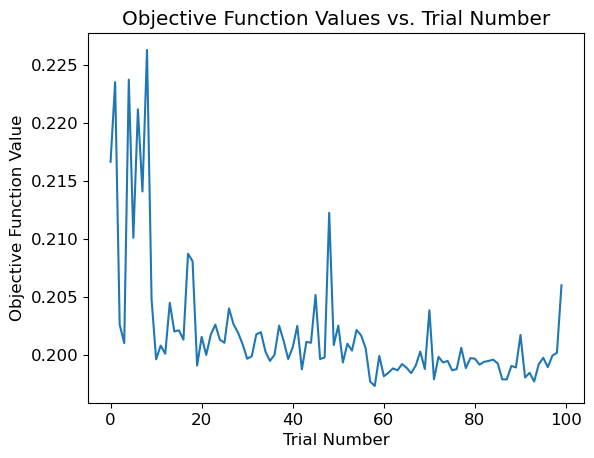

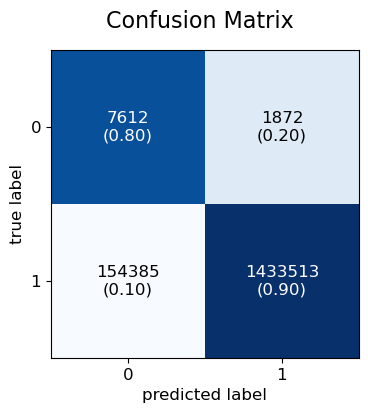

FP rate=FP/(FP+TN):  0.1974
Precision=TP/(TP+FP) :  0.9987
Recall=TP/(TP+FN) :  0.9028
AUC-PR:  0.9982
f1-score:  0.9483
roc_auc:  0.8527
Accuracy:  0.9022



 BEST PARAMS: {'n_estimators': 639, 'learning_rate': 0.1564451816120616, 'max_features': 235, 'min_samples_split': 0.10086195327610623, 'min_samples_leaf': 2, 'max_depth': 10}


In [77]:
trials_df = study.trials_dataframe()

sns.lineplot(trials_df, x='number',y='value')

plt.xlabel('Trial Number')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Values vs. Trial Number')

gbc_tuned=wrapper(GradientBoostingClassifier(**study.best_params)).fit(xbal,ybal)
performance_result(ytest,gbc_tuned.predict(xtest))


print('\n\n\n BEST PARAMS:',study.best_params)




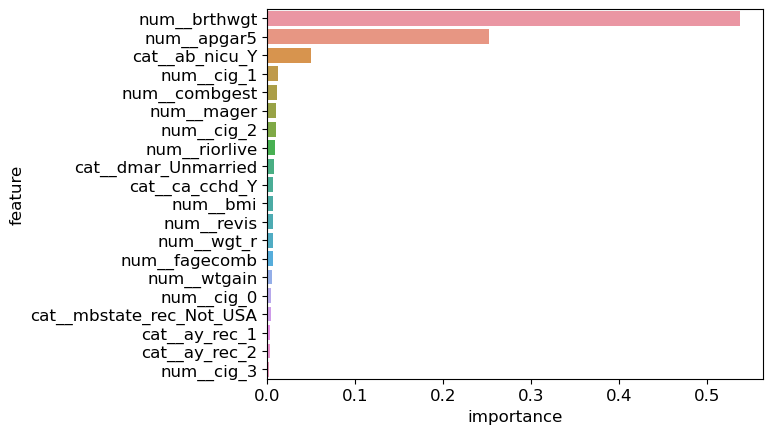

In [99]:
sns.set_palette("pastel")
sns.barplot(feature_importances(gbc_tuned).head(20),y='feature',x='importance',orient='h')
plt.show()





### GBC performs well as expected, with much predictive power being allocated to a few of the most important features.

In [97]:
optuna.logging.set_verbosity(optuna.logging.INFO) #set verbosity for optuna 

### It would appear that the 'binary:logistic' objective hyperparameter performs better than the default.

In [98]:


def objective_xgbc(trial):
    transformer=wrapper(None).col_transform
    x, y = transformer.fit_transform(xbal),ybal

    
    xgbc_params={'n_estimators' : trial.suggest_int("n_estimators", 200, 500),
    'learning_rate' : trial.suggest_float("learning_rate", 0.01, 0.25),
    'max_depth' : trial.suggest_int("max_depth", 1, 32),
                 'eta': trial.suggest_float("eta", 0.01, 0.5),
                 'max_delta_step': trial.suggest_int("max_delta_step", 0, 7),
                 'gamma' : trial.suggest_int("gamma", 0, 7),
                'objective' : 'binary:logistic',
                 'reg_lambda' : trial.suggest_float('reg_lambda', 0,1)}
    
    classifier_obj = XGBClassifier(**xgbc_params)
                                               

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=5,scoring=fp_rate)
    mean_metric = score.mean()
    return mean_metric

study_xgbc = optuna.create_study(direction="minimize")

study_xgbc.optimize(objective_xgbc, n_trials=25)




[I 2023-03-19 10:26:59,067] A new study created in memory with name: no-name-74426c95-251c-4166-a844-7dc8784f8fba
[I 2023-03-19 10:28:28,705] Trial 0 finished with value: 0.20163054684804918 and parameters: {'n_estimators': 250, 'learning_rate': 0.06944225059974087, 'max_depth': 15, 'eta': 0.2849577853743581, 'max_delta_step': 0, 'gamma': 1, 'reg_lambda': 0.4719875015611439}. Best is trial 0 with value: 0.20163054684804918.
[I 2023-03-19 10:31:39,176] Trial 1 finished with value: 0.20187273912940715 and parameters: {'n_estimators': 401, 'learning_rate': 0.14231311222015744, 'max_depth': 22, 'eta': 0.011709770244063096, 'max_delta_step': 6, 'gamma': 0, 'reg_lambda': 0.05984680308361767}. Best is trial 0 with value: 0.20163054684804918.
[I 2023-03-19 10:35:51,248] Trial 2 finished with value: 0.19988162569026194 and parameters: {'n_estimators': 394, 'learning_rate': 0.0941954023051446, 'max_depth': 28, 'eta': 0.31067509492202183, 'max_delta_step': 1, 'gamma': 1, 'reg_lambda': 0.604863170

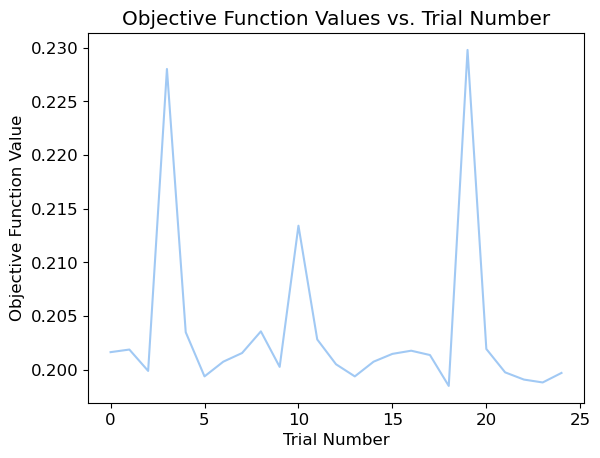

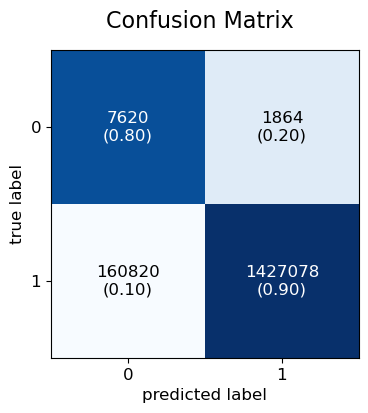

FP rate=FP/(FP+TN):  0.1965
Precision=TP/(TP+FP) :  0.9987
Recall=TP/(TP+FN) :  0.8987
AUC-PR:  0.9982
f1-score:  0.9461
roc_auc:  0.8511
Accuracy:  0.8982


 {'n_estimators': 639, 'learning_rate': 0.1564451816120616, 'max_features': 235, 'min_samples_split': 0.10086195327610623, 'min_samples_leaf': 2, 'max_depth': 10} 




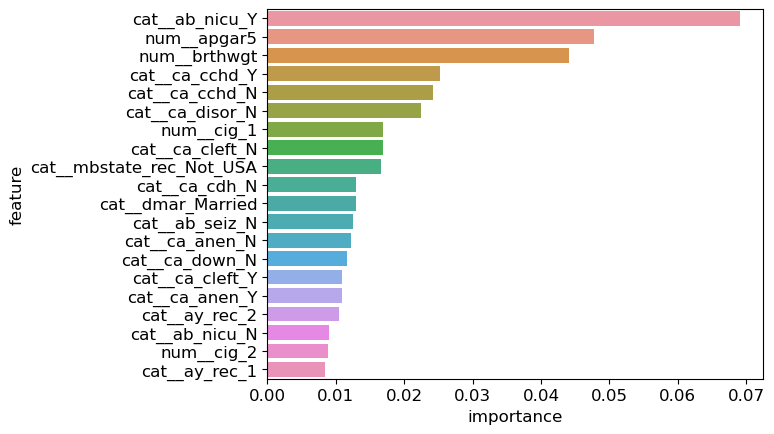

In [101]:


trials_df_xgbc = study_xgbc.trials_dataframe()

sns.lineplot(trials_df_xgbc, x='number',y='value')

plt.xlabel('Trial Number')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Values vs. Trial Number')

static_xgbc=study_xgbc.best_params.copy()

xgbc=wrapper(XGBClassifier(**static_xgbc)).fit(xbal,ybal)

performance_result(ytest,xgbc.predict(xtest))

print('\n\n',study.best_params,'\n\n')


sns.set_palette("pastel")
sns.barplot(feature_importances(xgbc).head(20),y='feature',x='importance',orient='h')
plt.show()

### Above we see that XGBoost has a lower false positive rate than GBC.

The predictive power of this classifier is much more evenly distributed among the input features. 

### LightGBMClassifier performed similarly to XGBoost and GradientBoostingClassifier but took much less time to train.

Because of this the number of trials used to train the classifier's hyperparameters was able to be much larger. While XGBoost was tuned over the course of 25 iterations, LightGBM was able to complete 250 in a similar amount of time. 

In [102]:
transformer=wrapper(None).col_transform
def obj_lgbm(trial):
    
    x, y = transformer.fit_transform(xbal),ybal

    
    
    params_lgbm = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 650),
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-5, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 1e-5, 1e-1),
        'min_split_gain': trial.suggest_uniform('min_split_gain', 0.0, 1.0)
    }
    classifier_obj = LGBMClassifier(**params_lgbm)
                                               

    score = cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=5, scoring=fp_rate)
    mean_metric = score.mean()
    
    print(mean_metric)
    return mean_metric

std_lgbm = optuna.create_study(direction="minimize")
std_lgbm.optimize(obj_lgbm, n_trials=250)




[I 2023-03-19 12:05:44,627] A new study created in memory with name: no-name-3f106112-7d65-43d4-9d60-652117ce8db2
[I 2023-03-19 12:05:54,450] Trial 0 finished with value: 0.2165900988839009 and parameters: {'n_estimators': 499, 'learning_rate': 0.009315729668010878, 'max_depth': 8, 'num_leaves': 27, 'reg_alpha': 0.10997337942273555, 'reg_lambda': 0.3644771013032446, 'colsample_bytree': 0.1526293595411791, 'subsample': 0.821602099383082, 'min_child_samples': 39, 'min_child_weight': 0.00782210191345629, 'min_split_gain': 0.27743500897950724}. Best is trial 0 with value: 0.2165900988839009.


0.2165900988839009


[I 2023-03-19 12:06:00,999] Trial 1 finished with value: 0.20163051789240088 and parameters: {'n_estimators': 510, 'learning_rate': 0.0666533248505902, 'max_depth': 10, 'num_leaves': 46, 'reg_alpha': 0.19487975761418141, 'reg_lambda': 0.9500769902630976, 'colsample_bytree': 0.3558619587845885, 'subsample': 0.29761149389084185, 'min_child_samples': 36, 'min_child_weight': 0.057431859595135436, 'min_split_gain': 0.06829872602280296}. Best is trial 1 with value: 0.20163051789240088.


0.20163051789240088


[I 2023-03-19 12:06:06,014] Trial 2 finished with value: 0.20843764334176992 and parameters: {'n_estimators': 393, 'learning_rate': 0.07040494974290291, 'max_depth': 4, 'num_leaves': 16, 'reg_alpha': 0.34550901355787467, 'reg_lambda': 0.24229792475588852, 'colsample_bytree': 0.2576542211758748, 'subsample': 0.5233240619724487, 'min_child_samples': 40, 'min_child_weight': 0.04893616732207116, 'min_split_gain': 0.4587611206316585}. Best is trial 1 with value: 0.20163051789240088.


0.20843764334176992


[I 2023-03-19 12:06:10,601] Trial 3 finished with value: 0.20154981850056722 and parameters: {'n_estimators': 597, 'learning_rate': 0.05959066737515958, 'max_depth': 8, 'num_leaves': 57, 'reg_alpha': 0.9554865593063021, 'reg_lambda': 0.15779455790870944, 'colsample_bytree': 0.7921615952626809, 'subsample': 0.5210946547291723, 'min_child_samples': 19, 'min_child_weight': 0.009809503916195374, 'min_split_gain': 0.5187892949070252}. Best is trial 3 with value: 0.20154981850056722.


0.20154981850056722


[I 2023-03-19 12:06:16,276] Trial 4 finished with value: 0.2058278273263212 and parameters: {'n_estimators': 408, 'learning_rate': 0.04086318728698531, 'max_depth': 6, 'num_leaves': 39, 'reg_alpha': 0.47530354033836675, 'reg_lambda': 0.37477473586978094, 'colsample_bytree': 0.24684004613128097, 'subsample': 0.13302387486467582, 'min_child_samples': 13, 'min_child_weight': 0.0316480320876996, 'min_split_gain': 0.13686794432673066}. Best is trial 3 with value: 0.20154981850056722.


0.2058278273263212


[I 2023-03-19 12:06:22,343] Trial 5 finished with value: 0.22119091613535766 and parameters: {'n_estimators': 427, 'learning_rate': 0.004898318746224814, 'max_depth': 7, 'num_leaves': 36, 'reg_alpha': 0.4462033790436929, 'reg_lambda': 0.40164972215621375, 'colsample_bytree': 0.23161980591790068, 'subsample': 0.8278853867922741, 'min_child_samples': 44, 'min_child_weight': 0.08301095983570551, 'min_split_gain': 0.6279889519669719}. Best is trial 3 with value: 0.20154981850056722.


0.22119091613535766


[I 2023-03-19 12:06:25,737] Trial 6 finished with value: 0.20582787799870578 and parameters: {'n_estimators': 361, 'learning_rate': 0.09968376862539952, 'max_depth': 5, 'num_leaves': 38, 'reg_alpha': 0.736343138292533, 'reg_lambda': 0.6929030891021585, 'colsample_bytree': 0.9001140718340918, 'subsample': 0.192753388316228, 'min_child_samples': 25, 'min_child_weight': 0.01586257987926251, 'min_split_gain': 0.9026335054241239}. Best is trial 3 with value: 0.20154981850056722.


0.20582787799870578


[I 2023-03-19 12:06:30,983] Trial 7 finished with value: 0.2048323357569573 and parameters: {'n_estimators': 386, 'learning_rate': 0.09434341804968095, 'max_depth': 7, 'num_leaves': 79, 'reg_alpha': 0.012962494178105133, 'reg_lambda': 0.936608751255123, 'colsample_bytree': 0.1669286312162001, 'subsample': 0.6524766929875027, 'min_child_samples': 48, 'min_child_weight': 0.042202176360860474, 'min_split_gain': 0.405829536698052}. Best is trial 3 with value: 0.20154981850056722.


0.2048323357569573


[I 2023-03-19 12:06:35,027] Trial 8 finished with value: 0.20660810242018185 and parameters: {'n_estimators': 483, 'learning_rate': 0.07504289768915788, 'max_depth': 4, 'num_leaves': 16, 'reg_alpha': 0.2812380038549882, 'reg_lambda': 0.1259222804990694, 'colsample_bytree': 0.6690860212280584, 'subsample': 0.9588153482576833, 'min_child_samples': 24, 'min_child_weight': 0.09113105357152519, 'min_split_gain': 0.6578359612641488}. Best is trial 3 with value: 0.20154981850056722.


0.20660810242018185


[I 2023-03-19 12:06:39,564] Trial 9 finished with value: 0.214087907393756 and parameters: {'n_estimators': 351, 'learning_rate': 0.0480116350152939, 'max_depth': 4, 'num_leaves': 94, 'reg_alpha': 0.16957643043295523, 'reg_lambda': 0.7323800997542506, 'colsample_bytree': 0.18062261703768334, 'subsample': 0.8392033472693446, 'min_child_samples': 42, 'min_child_weight': 0.09321910236689844, 'min_split_gain': 0.21057478717425293}. Best is trial 3 with value: 0.20154981850056722.


0.214087907393756


[I 2023-03-19 12:06:44,569] Trial 10 finished with value: 0.2014691227281896 and parameters: {'n_estimators': 644, 'learning_rate': 0.027235380319578797, 'max_depth': 10, 'num_leaves': 66, 'reg_alpha': 0.9363106629106686, 'reg_lambda': 0.0036300066957427324, 'colsample_bytree': 0.9960940762958322, 'subsample': 0.4423591794299258, 'min_child_samples': 7, 'min_child_weight': 0.004743096752607845, 'min_split_gain': 0.9971513601035216}. Best is trial 10 with value: 0.2014691227281896.


0.2014691227281896


[I 2023-03-19 12:06:49,078] Trial 11 finished with value: 0.20281445282095154 and parameters: {'n_estimators': 633, 'learning_rate': 0.03562771391652661, 'max_depth': 10, 'num_leaves': 66, 'reg_alpha': 0.9893109625802536, 'reg_lambda': 0.017788294586897457, 'colsample_bytree': 0.9802204180997524, 'subsample': 0.43184860200060526, 'min_child_samples': 6, 'min_child_weight': 0.0017372809414995284, 'min_split_gain': 0.9867174326919476}. Best is trial 10 with value: 0.2014691227281896.


0.20281445282095154


[I 2023-03-19 12:06:54,340] Trial 12 finished with value: 0.20233010083333994 and parameters: {'n_estimators': 645, 'learning_rate': 0.025751890837308507, 'max_depth': 9, 'num_leaves': 62, 'reg_alpha': 0.982212969867667, 'reg_lambda': 0.029127272961010725, 'colsample_bytree': 0.8338841893211729, 'subsample': 0.40473897677267284, 'min_child_samples': 15, 'min_child_weight': 0.021941227771277366, 'min_split_gain': 0.8170089279645159}. Best is trial 10 with value: 0.2014691227281896.


0.20233010083333994


[I 2023-03-19 12:06:59,642] Trial 13 finished with value: 0.20165743940641495 and parameters: {'n_estimators': 583, 'learning_rate': 0.02520081292285687, 'max_depth': 9, 'num_leaves': 73, 'reg_alpha': 0.7780443478369268, 'reg_lambda': 0.18138233054429304, 'colsample_bytree': 0.7534747636904944, 'subsample': 0.6009039320509764, 'min_child_samples': 5, 'min_child_weight': 0.00025467592722765164, 'min_split_gain': 0.7728769987056782}. Best is trial 10 with value: 0.2014691227281896.


0.20165743940641495


[I 2023-03-19 12:07:03,416] Trial 14 finished with value: 0.20372920880392145 and parameters: {'n_estimators': 587, 'learning_rate': 0.05527789567756359, 'max_depth': 8, 'num_leaves': 56, 'reg_alpha': 0.7914057310289526, 'reg_lambda': 0.20368452154524927, 'colsample_bytree': 0.9774018498261827, 'subsample': 0.4686596356006869, 'min_child_samples': 16, 'min_child_weight': 0.018983145202985177, 'min_split_gain': 0.9829708923403232}. Best is trial 10 with value: 0.2014691227281896.


0.20372920880392145


[I 2023-03-19 12:07:07,466] Trial 15 finished with value: 0.20359460847276295 and parameters: {'n_estimators': 588, 'learning_rate': 0.05501071566908439, 'max_depth': 9, 'num_leaves': 87, 'reg_alpha': 0.6091737414751279, 'reg_lambda': 0.004289521588621482, 'colsample_bytree': 0.6455557111450037, 'subsample': 0.34028624113860373, 'min_child_samples': 20, 'min_child_weight': 0.02757208451860618, 'min_split_gain': 0.6299585923090899}. Best is trial 10 with value: 0.2014691227281896.


0.20359460847276295


[I 2023-03-19 12:07:12,879] Trial 16 finished with value: 0.20356778468406186 and parameters: {'n_estimators': 551, 'learning_rate': 0.019717904407408848, 'max_depth': 8, 'num_leaves': 54, 'reg_alpha': 0.8903195626944963, 'reg_lambda': 0.1362961540019885, 'colsample_bytree': 0.8175588504930207, 'subsample': 0.5857149999195728, 'min_child_samples': 10, 'min_child_weight': 0.01209309551611798, 'min_split_gain': 0.3490783774147648}. Best is trial 10 with value: 0.2014691227281896.


0.20356778468406186


[I 2023-03-19 12:07:19,933] Trial 17 finished with value: 0.20130770222778605 and parameters: {'n_estimators': 618, 'learning_rate': 0.03501028371072755, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.6387042004108078, 'reg_lambda': 0.27058516938845456, 'colsample_bytree': 0.49857524658037017, 'subsample': 0.2599662386022151, 'min_child_samples': 28, 'min_child_weight': 0.00022656348749469386, 'min_split_gain': 0.4949858156533078}. Best is trial 17 with value: 0.20130770222778605.


0.20130770222778605


[I 2023-03-19 12:07:24,990] Trial 18 finished with value: 0.20163053960913713 and parameters: {'n_estimators': 544, 'learning_rate': 0.03619999963637611, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6305278740500156, 'reg_lambda': 0.279847440152139, 'colsample_bytree': 0.4912514969472394, 'subsample': 0.2549041767674967, 'min_child_samples': 32, 'min_child_weight': 0.0003912712590267457, 'min_split_gain': 0.5341674052425385}. Best is trial 17 with value: 0.20130770222778605.


0.20163053960913713


[I 2023-03-19 12:07:31,060] Trial 19 finished with value: 0.2238008117788392 and parameters: {'n_estimators': 619, 'learning_rate': 0.016669048177861988, 'max_depth': 3, 'num_leaves': 85, 'reg_alpha': 0.6020951990223302, 'reg_lambda': 0.5191964806481771, 'colsample_bytree': 0.512609001989708, 'subsample': 0.1219916715828136, 'min_child_samples': 32, 'min_child_weight': 0.0317294815995686, 'min_split_gain': 0.7826136181974256}. Best is trial 17 with value: 0.20130770222778605.


0.2238008117788392


[I 2023-03-19 12:07:36,727] Trial 20 finished with value: 0.21123595700824596 and parameters: {'n_estimators': 458, 'learning_rate': 0.0021308571928067357, 'max_depth': 10, 'num_leaves': 74, 'reg_alpha': 0.844183802105198, 'reg_lambda': 0.10449315528673682, 'colsample_bytree': 0.584946232075754, 'subsample': 0.35320328630887127, 'min_child_samples': 30, 'min_child_weight': 0.01431813268330481, 'min_split_gain': 0.371513650834557}. Best is trial 17 with value: 0.20130770222778605.


0.21123595700824596


[I 2023-03-19 12:07:42,296] Trial 21 finished with value: 0.2019534421406969 and parameters: {'n_estimators': 614, 'learning_rate': 0.02765732222252574, 'max_depth': 9, 'num_leaves': 51, 'reg_alpha': 0.8937525253610958, 'reg_lambda': 0.09486776862239732, 'colsample_bytree': 0.9971687656277884, 'subsample': 0.2821412636800918, 'min_child_samples': 20, 'min_child_weight': 0.00861960511093941, 'min_split_gain': 0.5258843795778678}. Best is trial 17 with value: 0.20130770222778605.


0.2019534421406969


[I 2023-03-19 12:07:46,918] Trial 22 finished with value: 0.20249153581156762 and parameters: {'n_estimators': 649, 'learning_rate': 0.044504544597929525, 'max_depth': 8, 'num_leaves': 65, 'reg_alpha': 0.9981758274404684, 'reg_lambda': 0.27488128235682086, 'colsample_bytree': 0.765666257035667, 'subsample': 0.49351372454706377, 'min_child_samples': 20, 'min_child_weight': 0.007902459232607236, 'min_split_gain': 0.4828072607732208}. Best is trial 17 with value: 0.20130770222778605.


0.20249153581156762


[I 2023-03-19 12:07:52,672] Trial 23 finished with value: 0.20111942536357708 and parameters: {'n_estimators': 563, 'learning_rate': 0.03332005468426752, 'max_depth': 9, 'num_leaves': 93, 'reg_alpha': 0.7066085322006768, 'reg_lambda': 0.1788342397565697, 'colsample_bytree': 0.9232592899782581, 'subsample': 0.395570730742681, 'min_child_samples': 10, 'min_child_weight': 0.022484127025223212, 'min_split_gain': 0.29374151142741867}. Best is trial 23 with value: 0.20111942536357708.


0.20111942536357708


[I 2023-03-19 12:07:58,152] Trial 24 finished with value: 0.20025840382495427 and parameters: {'n_estimators': 555, 'learning_rate': 0.03612885080631523, 'max_depth': 10, 'num_leaves': 91, 'reg_alpha': 0.7101905919486148, 'reg_lambda': 0.052981224574957075, 'colsample_bytree': 0.9009139137740367, 'subsample': 0.3797361382053898, 'min_child_samples': 12, 'min_child_weight': 0.020135147064912363, 'min_split_gain': 0.2840537718982954}. Best is trial 24 with value: 0.20025840382495427.


0.20025840382495427


[I 2023-03-19 12:08:03,781] Trial 25 finished with value: 0.20136150906125388 and parameters: {'n_estimators': 549, 'learning_rate': 0.03358726960634399, 'max_depth': 9, 'num_leaves': 100, 'reg_alpha': 0.6781436691552765, 'reg_lambda': 0.24071181174139422, 'colsample_bytree': 0.8970206599693785, 'subsample': 0.2206194407595825, 'min_child_samples': 11, 'min_child_weight': 0.025531953523442813, 'min_split_gain': 0.2861678475761551}. Best is trial 24 with value: 0.20025840382495427.


0.20136150906125388


[I 2023-03-19 12:08:09,839] Trial 26 finished with value: 0.20068883315650482 and parameters: {'n_estimators': 528, 'learning_rate': 0.04205980453843775, 'max_depth': 10, 'num_leaves': 90, 'reg_alpha': 0.5398170859569564, 'reg_lambda': 0.07842239141498661, 'colsample_bytree': 0.43539998228201815, 'subsample': 0.3626666368802736, 'min_child_samples': 25, 'min_child_weight': 0.018457234052460345, 'min_split_gain': 0.19343587304150817}. Best is trial 24 with value: 0.20025840382495427.


0.20068883315650482


[I 2023-03-19 12:08:16,698] Trial 27 finished with value: 0.19902073807151255 and parameters: {'n_estimators': 564, 'learning_rate': 0.0412684095174794, 'max_depth': 9, 'num_leaves': 89, 'reg_alpha': 0.5610959585042552, 'reg_lambda': 0.07756921465376257, 'colsample_bytree': 0.3831972319524364, 'subsample': 0.3794904828596378, 'min_child_samples': 9, 'min_child_weight': 0.0213753188319184, 'min_split_gain': 0.1583589254970577}. Best is trial 27 with value: 0.19902073807151255.


0.19902073807151255


[I 2023-03-19 12:08:21,776] Trial 28 finished with value: 0.20227627228313586 and parameters: {'n_estimators': 518, 'learning_rate': 0.04173325605478606, 'max_depth': 6, 'num_leaves': 85, 'reg_alpha': 0.5503707641215018, 'reg_lambda': 0.07609031748746423, 'colsample_bytree': 0.42482118932395996, 'subsample': 0.3534412569872618, 'min_child_samples': 17, 'min_child_weight': 0.03822741536148083, 'min_split_gain': 0.014092261470512762}. Best is trial 27 with value: 0.19902073807151255.


0.20227627228313586


[I 2023-03-19 12:08:28,434] Trial 29 finished with value: 0.20905652689087528 and parameters: {'n_estimators': 530, 'learning_rate': 0.012097335302754197, 'max_depth': 7, 'num_leaves': 80, 'reg_alpha': 0.5348356817899996, 'reg_lambda': 0.0733626872947716, 'colsample_bytree': 0.345977810391197, 'subsample': 0.3829023994425095, 'min_child_samples': 24, 'min_child_weight': 0.017753753058412845, 'min_split_gain': 0.19989175568878115}. Best is trial 27 with value: 0.19902073807151255.


0.20905652689087528


[I 2023-03-19 12:08:34,218] Trial 30 finished with value: 0.19937050782524585 and parameters: {'n_estimators': 487, 'learning_rate': 0.05021931744755788, 'max_depth': 10, 'num_leaves': 93, 'reg_alpha': 0.44052181913179517, 'reg_lambda': 0.3265575948434294, 'colsample_bytree': 0.4270870639090415, 'subsample': 0.3220515456034381, 'min_child_samples': 13, 'min_child_weight': 0.029079555902577187, 'min_split_gain': 0.15034690815192497}. Best is trial 27 with value: 0.19902073807151255.


0.19937050782524585


[I 2023-03-19 12:08:39,994] Trial 31 finished with value: 0.19918208980225136 and parameters: {'n_estimators': 491, 'learning_rate': 0.05032011478333034, 'max_depth': 10, 'num_leaves': 92, 'reg_alpha': 0.41448834296644554, 'reg_lambda': 0.08921465844897769, 'colsample_bytree': 0.4372370842718469, 'subsample': 0.31693260577115134, 'min_child_samples': 9, 'min_child_weight': 0.02870626483890502, 'min_split_gain': 0.16859508651551103}. Best is trial 27 with value: 0.19902073807151255.


0.19918208980225136


[I 2023-03-19 12:08:46,260] Trial 32 finished with value: 0.19942432551708184 and parameters: {'n_estimators': 490, 'learning_rate': 0.04911859793449143, 'max_depth': 10, 'num_leaves': 79, 'reg_alpha': 0.4167097808624482, 'reg_lambda': 0.15018351713419048, 'colsample_bytree': 0.35742807279403255, 'subsample': 0.3054364784691475, 'min_child_samples': 8, 'min_child_weight': 0.03189713443088707, 'min_split_gain': 0.08943840432865427}. Best is trial 27 with value: 0.19902073807151255.


0.19942432551708184


[I 2023-03-19 12:08:52,348] Trial 33 finished with value: 0.19977408803190305 and parameters: {'n_estimators': 487, 'learning_rate': 0.04984612190384916, 'max_depth': 9, 'num_leaves': 80, 'reg_alpha': 0.38706438601347826, 'reg_lambda': 0.3056280015007305, 'colsample_bytree': 0.36610792415776444, 'subsample': 0.30306997385970563, 'min_child_samples': 8, 'min_child_weight': 0.03491930458584546, 'min_split_gain': 0.095898496833655}. Best is trial 27 with value: 0.19902073807151255.


0.19977408803190305


[I 2023-03-19 12:08:58,494] Trial 34 finished with value: 0.20052748504522203 and parameters: {'n_estimators': 462, 'learning_rate': 0.06036706942346204, 'max_depth': 10, 'num_leaves': 73, 'reg_alpha': 0.4245978974843247, 'reg_lambda': 0.18044122964592071, 'colsample_bytree': 0.310790489335838, 'subsample': 0.3090894919223108, 'min_child_samples': 14, 'min_child_weight': 0.043233229172457636, 'min_split_gain': 0.05300731923876788}. Best is trial 27 with value: 0.19902073807151255.


0.20052748504522203


[I 2023-03-19 12:09:05,057] Trial 35 finished with value: 0.1992359979804883 and parameters: {'n_estimators': 463, 'learning_rate': 0.05165592789089213, 'max_depth': 9, 'num_leaves': 94, 'reg_alpha': 0.33801665909979783, 'reg_lambda': 0.13753621615292483, 'colsample_bytree': 0.41534919599602305, 'subsample': 0.2199469931675919, 'min_child_samples': 8, 'min_child_weight': 0.029382324563264714, 'min_split_gain': 0.0009762332224391712}. Best is trial 27 with value: 0.19902073807151255.


0.1992359979804883


[I 2023-03-19 12:09:11,435] Trial 36 finished with value: 0.19955877383108672 and parameters: {'n_estimators': 459, 'learning_rate': 0.061886814404891466, 'max_depth': 8, 'num_leaves': 95, 'reg_alpha': 0.3212831714323631, 'reg_lambda': 0.21791335193492448, 'colsample_bytree': 0.41525108689867685, 'subsample': 0.1989333326425038, 'min_child_samples': 5, 'min_child_weight': 0.027124216575371188, 'min_split_gain': 0.003752827016182486}. Best is trial 27 with value: 0.19902073807151255.


0.19955877383108672


[I 2023-03-19 12:09:17,474] Trial 37 finished with value: 0.201388426955812 and parameters: {'n_estimators': 435, 'learning_rate': 0.056196519549616616, 'max_depth': 9, 'num_leaves': 89, 'reg_alpha': 0.4877263271737743, 'reg_lambda': 0.3149280333862132, 'colsample_bytree': 0.28933795487022135, 'subsample': 0.16505664167166764, 'min_child_samples': 9, 'min_child_weight': 0.05915029904365761, 'min_split_gain': 0.13429380135338664}. Best is trial 27 with value: 0.19902073807151255.


0.201388426955812


[I 2023-03-19 12:09:22,300] Trial 38 finished with value: 0.200715761909431 and parameters: {'n_estimators': 438, 'learning_rate': 0.0674210904389963, 'max_depth': 8, 'num_leaves': 83, 'reg_alpha': 0.36237888850589534, 'reg_lambda': 0.12806299254475992, 'colsample_bytree': 0.4581648082195896, 'subsample': 0.23306240494742386, 'min_child_samples': 13, 'min_child_weight': 0.027496251382121834, 'min_split_gain': 0.1430064968128077}. Best is trial 27 with value: 0.19902073807151255.


0.200715761909431


[I 2023-03-19 12:09:27,693] Trial 39 finished with value: 0.20224943039715457 and parameters: {'n_estimators': 505, 'learning_rate': 0.04630486305067847, 'max_depth': 7, 'num_leaves': 29, 'reg_alpha': 0.28162589507857827, 'reg_lambda': 0.3510532169871112, 'colsample_bytree': 0.3727800124346629, 'subsample': 0.1583734658599399, 'min_child_samples': 17, 'min_child_weight': 0.013453944978873828, 'min_split_gain': 0.03867318594097364}. Best is trial 27 with value: 0.19902073807151255.


0.20224943039715457


[I 2023-03-19 12:09:32,304] Trial 40 finished with value: 0.20467089715927358 and parameters: {'n_estimators': 468, 'learning_rate': 0.05261086745992033, 'max_depth': 5, 'num_leaves': 96, 'reg_alpha': 0.4628760304983602, 'reg_lambda': 0.21042620790528968, 'colsample_bytree': 0.3955183839068961, 'subsample': 0.11468976231598116, 'min_child_samples': 12, 'min_child_weight': 0.04953441205658575, 'min_split_gain': 0.06633200760153535}. Best is trial 27 with value: 0.19902073807151255.


0.20467089715927358


[I 2023-03-19 12:09:38,952] Trial 41 finished with value: 0.19993558816033946 and parameters: {'n_estimators': 492, 'learning_rate': 0.0478225827493595, 'max_depth': 10, 'num_leaves': 92, 'reg_alpha': 0.39256562480186696, 'reg_lambda': 0.15013854313487485, 'colsample_bytree': 0.3336903001660818, 'subsample': 0.27798051421760644, 'min_child_samples': 10, 'min_child_weight': 0.03167917682441459, 'min_split_gain': 0.10623028732192612}. Best is trial 27 with value: 0.19902073807151255.


0.19993558816033946


[I 2023-03-19 12:09:45,370] Trial 42 finished with value: 0.2000969797050947 and parameters: {'n_estimators': 478, 'learning_rate': 0.05139528292740227, 'max_depth': 9, 'num_leaves': 76, 'reg_alpha': 0.43054775446708093, 'reg_lambda': 0.14453174431662166, 'colsample_bytree': 0.2845045097581168, 'subsample': 0.3162923914522322, 'min_child_samples': 8, 'min_child_weight': 0.0370464565204968, 'min_split_gain': 0.07535647323594885}. Best is trial 27 with value: 0.19902073807151255.


0.2000969797050947


[I 2023-03-19 12:09:52,328] Trial 43 finished with value: 0.19977401564278224 and parameters: {'n_estimators': 503, 'learning_rate': 0.04140561202865685, 'max_depth': 10, 'num_leaves': 82, 'reg_alpha': 0.33316936050873813, 'reg_lambda': 0.05829528807223905, 'colsample_bytree': 0.4550641393701016, 'subsample': 0.22201301141677865, 'min_child_samples': 7, 'min_child_weight': 0.024057798994742488, 'min_split_gain': 0.18141387669312015}. Best is trial 27 with value: 0.19902073807151255.


0.19977401564278224


[I 2023-03-19 12:09:58,461] Trial 44 finished with value: 0.20284133090149323 and parameters: {'n_estimators': 441, 'learning_rate': 0.04750440612107927, 'max_depth': 10, 'num_leaves': 89, 'reg_alpha': 0.4937196592446154, 'reg_lambda': 0.23330011825036506, 'colsample_bytree': 0.2294205583999661, 'subsample': 0.18192724747154662, 'min_child_samples': 38, 'min_child_weight': 0.030820937258873724, 'min_split_gain': 0.2323144263878985}. Best is trial 27 with value: 0.19902073807151255.


0.20284133090149323


[I 2023-03-19 12:10:03,666] Trial 45 finished with value: 0.20036597405841752 and parameters: {'n_estimators': 412, 'learning_rate': 0.06266596666528183, 'max_depth': 9, 'num_leaves': 45, 'reg_alpha': 0.420607244577035, 'reg_lambda': 0.11346403929274919, 'colsample_bytree': 0.3839509269548393, 'subsample': 0.424302321044447, 'min_child_samples': 5, 'min_child_weight': 0.04090319251198335, 'min_split_gain': 0.13819080434628014}. Best is trial 27 with value: 0.19902073807151255.


0.20036597405841752


[I 2023-03-19 12:10:10,133] Trial 46 finished with value: 0.1995857568758535 and parameters: {'n_estimators': 515, 'learning_rate': 0.05764417525661075, 'max_depth': 10, 'num_leaves': 70, 'reg_alpha': 0.23691329359130198, 'reg_lambda': 0.03129672169553585, 'colsample_bytree': 0.33816674730389606, 'subsample': 0.24565082438199498, 'min_child_samples': 15, 'min_child_weight': 0.034556596973963606, 'min_split_gain': 9.24083428725242e-05}. Best is trial 27 with value: 0.19902073807151255.


0.1995857568758535


[I 2023-03-19 12:10:15,717] Trial 47 finished with value: 0.20079648663745697 and parameters: {'n_estimators': 475, 'learning_rate': 0.052813537901017185, 'max_depth': 8, 'num_leaves': 77, 'reg_alpha': 0.37210917852278486, 'reg_lambda': 0.15704414383990617, 'colsample_bytree': 0.39236621827510465, 'subsample': 0.3293008699126495, 'min_child_samples': 8, 'min_child_weight': 0.02291903721195117, 'min_split_gain': 0.09901467559232395}. Best is trial 27 with value: 0.19902073807151255.


0.20079648663745697


[I 2023-03-19 12:10:20,488] Trial 48 finished with value: 0.19985480190156085 and parameters: {'n_estimators': 451, 'learning_rate': 0.04954047970104323, 'max_depth': 9, 'num_leaves': 96, 'reg_alpha': 0.456592923132512, 'reg_lambda': 0.001717663907422673, 'colsample_bytree': 0.5357032820147131, 'subsample': 0.4666501031919941, 'min_child_samples': 22, 'min_child_weight': 0.015138130812638649, 'min_split_gain': 0.2406760962803033}. Best is trial 27 with value: 0.19902073807151255.


0.19985480190156085


[I 2023-03-19 12:10:24,239] Trial 49 finished with value: 0.20798032869076563 and parameters: {'n_estimators': 416, 'learning_rate': 0.04437644272214309, 'max_depth': 9, 'num_leaves': 10, 'reg_alpha': 0.30597730276062546, 'reg_lambda': 0.19044004097818407, 'colsample_bytree': 0.4483149060343594, 'subsample': 0.2890869923125137, 'min_child_samples': 13, 'min_child_weight': 0.04434345521363933, 'min_split_gain': 0.1530445649162276}. Best is trial 27 with value: 0.19902073807151255.


0.20798032869076563


[I 2023-03-19 12:10:29,856] Trial 50 finished with value: 0.200150735866178 and parameters: {'n_estimators': 379, 'learning_rate': 0.07415538407318659, 'max_depth': 10, 'num_leaves': 86, 'reg_alpha': 0.2449010523224674, 'reg_lambda': 0.10733766237665374, 'colsample_bytree': 0.4880669272959246, 'subsample': 0.3231279351845995, 'min_child_samples': 46, 'min_child_weight': 0.02969679902420557, 'min_split_gain': 0.05246444674410296}. Best is trial 27 with value: 0.19902073807151255.


0.200150735866178


[I 2023-03-19 12:10:36,513] Trial 51 finished with value: 0.19926283262755753 and parameters: {'n_estimators': 491, 'learning_rate': 0.06313887791056685, 'max_depth': 8, 'num_leaves': 93, 'reg_alpha': 0.3365709371161856, 'reg_lambda': 0.22467454415443924, 'colsample_bytree': 0.4131432560242057, 'subsample': 0.1972333283596145, 'min_child_samples': 5, 'min_child_weight': 0.026583175781480464, 'min_split_gain': 0.0038037834822880175}. Best is trial 27 with value: 0.19902073807151255.


0.19926283262755753


[I 2023-03-19 12:10:42,332] Trial 52 finished with value: 0.19947809977544534 and parameters: {'n_estimators': 494, 'learning_rate': 0.06518033795463744, 'max_depth': 8, 'num_leaves': 93, 'reg_alpha': 0.3383506898097671, 'reg_lambda': 0.23825489366582575, 'colsample_bytree': 0.395237053753568, 'subsample': 0.20121282275632008, 'min_child_samples': 7, 'min_child_weight': 0.024250632263848805, 'min_split_gain': 0.04082745730976989}. Best is trial 27 with value: 0.19902073807151255.


0.19947809977544534


[I 2023-03-19 12:10:49,443] Trial 53 finished with value: 0.1982672397134245 and parameters: {'n_estimators': 525, 'learning_rate': 0.05603054710986766, 'max_depth': 9, 'num_leaves': 100, 'reg_alpha': 0.39859608976432137, 'reg_lambda': 0.16212637039630975, 'colsample_bytree': 0.46794671560152606, 'subsample': 0.26103717766420353, 'min_child_samples': 5, 'min_child_weight': 0.034576847116912994, 'min_split_gain': 0.10221432658831606}. Best is trial 53 with value: 0.1982672397134245.


0.1982672397134245


[I 2023-03-19 12:10:54,993] Trial 54 finished with value: 0.1989937586462018 and parameters: {'n_estimators': 531, 'learning_rate': 0.05819060806986322, 'max_depth': 9, 'num_leaves': 100, 'reg_alpha': 0.3716988473123986, 'reg_lambda': 0.04712825826150205, 'colsample_bytree': 0.5666976655004984, 'subsample': 0.15707926473849548, 'min_child_samples': 5, 'min_child_weight': 0.011218877777311963, 'min_split_gain': 0.10816361284927896}. Best is trial 53 with value: 0.1982672397134245.


0.1989937586462018


[I 2023-03-19 12:11:00,615] Trial 55 finished with value: 0.19998931174631843 and parameters: {'n_estimators': 570, 'learning_rate': 0.05995947239896863, 'max_depth': 8, 'num_leaves': 97, 'reg_alpha': 0.3619080015713362, 'reg_lambda': 0.04156661468967188, 'colsample_bytree': 0.5643858877204246, 'subsample': 0.15054150494891763, 'min_child_samples': 5, 'min_child_weight': 0.006077882199008868, 'min_split_gain': 0.1081595632761426}. Best is trial 53 with value: 0.1982672397134245.


0.19998931174631843


[I 2023-03-19 12:11:06,267] Trial 56 finished with value: 0.1998547584680884 and parameters: {'n_estimators': 572, 'learning_rate': 0.05571318417306753, 'max_depth': 7, 'num_leaves': 100, 'reg_alpha': 0.1846387682107022, 'reg_lambda': 0.09407308746517613, 'colsample_bytree': 0.47618234331520237, 'subsample': 0.13127275035013286, 'min_child_samples': 6, 'min_child_weight': 0.017044813438764742, 'min_split_gain': 0.027665908346419677}. Best is trial 53 with value: 0.1982672397134245.


0.1998547584680884


[I 2023-03-19 12:11:11,632] Trial 57 finished with value: 0.19859025082866538 and parameters: {'n_estimators': 524, 'learning_rate': 0.07124745023608015, 'max_depth': 9, 'num_leaves': 88, 'reg_alpha': 0.2963457402782952, 'reg_lambda': 0.056434993372030735, 'colsample_bytree': 0.5439765476355475, 'subsample': 0.10239285288235299, 'min_child_samples': 10, 'min_child_weight': 0.010594558104107966, 'min_split_gain': 0.07228518311189694}. Best is trial 53 with value: 0.1982672397134245.


0.19859025082866538


[I 2023-03-19 12:11:16,419] Trial 58 finished with value: 0.19942427122524126 and parameters: {'n_estimators': 533, 'learning_rate': 0.07214932995626011, 'max_depth': 9, 'num_leaves': 89, 'reg_alpha': 0.14659382201407894, 'reg_lambda': 0.059745971785724446, 'colsample_bytree': 0.5917506000690117, 'subsample': 0.15266616491104956, 'min_child_samples': 10, 'min_child_weight': 0.011405287303653179, 'min_split_gain': 0.17457516555107339}. Best is trial 53 with value: 0.1982672397134245.


0.19942427122524126


[I 2023-03-19 12:11:20,695] Trial 59 finished with value: 0.20044670964481157 and parameters: {'n_estimators': 540, 'learning_rate': 0.07896100076582083, 'max_depth': 9, 'num_leaves': 100, 'reg_alpha': 0.39785580078448296, 'reg_lambda': 0.0026639033139386203, 'colsample_bytree': 0.534661684934143, 'subsample': 0.10232267054544206, 'min_child_samples': 11, 'min_child_weight': 0.008701943186866755, 'min_split_gain': 0.24229694820665873}. Best is trial 53 with value: 0.1982672397134245.


0.20044670964481157


[I 2023-03-19 12:11:26,056] Trial 60 finished with value: 0.19815971653288975 and parameters: {'n_estimators': 519, 'learning_rate': 0.0692221217082638, 'max_depth': 9, 'num_leaves': 87, 'reg_alpha': 0.29266674995899855, 'reg_lambda': 0.04302383092222425, 'colsample_bytree': 0.50547674518498, 'subsample': 0.258520086277326, 'min_child_samples': 7, 'min_child_weight': 0.003961259713088151, 'min_split_gain': 0.07635587715308957}. Best is trial 60 with value: 0.19815971653288975.


0.19815971653288975


[I 2023-03-19 12:11:32,980] Trial 61 finished with value: 0.19990857254046832 and parameters: {'n_estimators': 527, 'learning_rate': 0.06835484046341299, 'max_depth': 9, 'num_leaves': 87, 'reg_alpha': 0.29487932704027553, 'reg_lambda': 0.03278540210933892, 'colsample_bytree': 0.5238491831037676, 'subsample': 0.2586412345464045, 'min_child_samples': 7, 'min_child_weight': 0.0054300497988295435, 'min_split_gain': 0.07659759260127826}. Best is trial 60 with value: 0.19815971653288975.


0.19990857254046832


[I 2023-03-19 12:11:38,531] Trial 62 finished with value: 0.20090406049037624 and parameters: {'n_estimators': 516, 'learning_rate': 0.05793902136492367, 'max_depth': 9, 'num_leaves': 97, 'reg_alpha': 0.25368106360342196, 'reg_lambda': 0.08772584006978991, 'colsample_bytree': 0.49264021216466697, 'subsample': 0.1767733944881478, 'min_child_samples': 9, 'min_child_weight': 0.010819340695184091, 'min_split_gain': 0.12007692475072863}. Best is trial 60 with value: 0.19815971653288975.


0.20090406049037624


[I 2023-03-19 12:11:43,686] Trial 63 finished with value: 0.199585709822925 and parameters: {'n_estimators': 506, 'learning_rate': 0.07000729490651078, 'max_depth': 9, 'num_leaves': 83, 'reg_alpha': 0.21565095115228916, 'reg_lambda': 0.123927816810464, 'colsample_bytree': 0.5705263184506496, 'subsample': 0.23306709033761758, 'min_child_samples': 11, 'min_child_weight': 0.02123294429847615, 'min_split_gain': 0.05397393771472862}. Best is trial 60 with value: 0.19815971653288975.


0.199585709822925


[I 2023-03-19 12:11:48,607] Trial 64 finished with value: 0.20154981126165517 and parameters: {'n_estimators': 560, 'learning_rate': 0.0657166318872388, 'max_depth': 8, 'num_leaves': 90, 'reg_alpha': 0.28034174383418076, 'reg_lambda': 0.048215564220154064, 'colsample_bytree': 0.4737216640713845, 'subsample': 0.27373412135569664, 'min_child_samples': 50, 'min_child_weight': 0.002908479605950264, 'min_split_gain': 0.1690303585493486}. Best is trial 60 with value: 0.19815971653288975.


0.20154981126165517


[I 2023-03-19 12:11:52,099] Trial 65 finished with value: 0.20814171661606484 and parameters: {'n_estimators': 538, 'learning_rate': 0.07926858240888168, 'max_depth': 3, 'num_leaves': 87, 'reg_alpha': 0.36235419190207663, 'reg_lambda': 0.07915883069394727, 'colsample_bytree': 0.6041976313224188, 'subsample': 0.10403149579094194, 'min_child_samples': 9, 'min_child_weight': 0.015328845223975691, 'min_split_gain': 0.0798183411338859}. Best is trial 60 with value: 0.19815971653288975.


0.20814171661606484


[I 2023-03-19 12:11:57,000] Trial 66 finished with value: 0.20181889972083494 and parameters: {'n_estimators': 577, 'learning_rate': 0.05274595632913425, 'max_depth': 6, 'num_leaves': 95, 'reg_alpha': 0.47723027740902757, 'reg_lambda': 0.17123305908596584, 'colsample_bytree': 0.5413607973107536, 'subsample': 0.14242474393122734, 'min_child_samples': 6, 'min_child_weight': 0.003946848928277824, 'min_split_gain': 0.12417853491751896}. Best is trial 60 with value: 0.19815971653288975.


0.20181889972083494


[I 2023-03-19 12:12:03,847] Trial 67 finished with value: 0.20090410754330473 and parameters: {'n_estimators': 522, 'learning_rate': 0.03860767002736038, 'max_depth': 9, 'num_leaves': 59, 'reg_alpha': 0.3183691716210461, 'reg_lambda': 0.028851805151249278, 'colsample_bytree': 0.522459520732908, 'subsample': 0.2143017293044496, 'min_child_samples': 15, 'min_child_weight': 0.018773613844032314, 'min_split_gain': 0.19579834986329103}. Best is trial 60 with value: 0.19815971653288975.


0.20090410754330473


[I 2023-03-19 12:12:09,474] Trial 68 finished with value: 0.19998929364903822 and parameters: {'n_estimators': 598, 'learning_rate': 0.05917494255773584, 'max_depth': 9, 'num_leaves': 69, 'reg_alpha': 0.3906413403844166, 'reg_lambda': 0.11868673579061356, 'colsample_bytree': 0.504819081637349, 'subsample': 0.25232552524516183, 'min_child_samples': 7, 'min_child_weight': 0.012016390290472613, 'min_split_gain': 0.039018460145096065}. Best is trial 60 with value: 0.19815971653288975.


0.19998929364903822


[I 2023-03-19 12:12:14,736] Trial 69 finished with value: 0.20009694712999032 and parameters: {'n_estimators': 546, 'learning_rate': 0.053927049036852415, 'max_depth': 8, 'num_leaves': 98, 'reg_alpha': 0.5137019406293089, 'reg_lambda': 0.07800130891410209, 'colsample_bytree': 0.6275250097599955, 'subsample': 0.1803355196858334, 'min_child_samples': 17, 'min_child_weight': 0.00993558613043196, 'min_split_gain': 0.158769006785045}. Best is trial 60 with value: 0.19815971653288975.


0.20009694712999032


[I 2023-03-19 12:12:19,097] Trial 70 finished with value: 0.2058009166706752 and parameters: {'n_estimators': 511, 'learning_rate': 0.04556344222500594, 'max_depth': 5, 'num_leaves': 83, 'reg_alpha': 0.5679309448239432, 'reg_lambda': 0.02237930742161453, 'colsample_bytree': 0.4663552142586237, 'subsample': 0.3634736114080772, 'min_child_samples': 12, 'min_child_weight': 0.007220253635017685, 'min_split_gain': 0.1238029372064317}. Best is trial 60 with value: 0.19815971653288975.


0.2058009166706752


[I 2023-03-19 12:12:25,832] Trial 71 finished with value: 0.1990475582407576 and parameters: {'n_estimators': 500, 'learning_rate': 0.06573848127520922, 'max_depth': 8, 'num_leaves': 92, 'reg_alpha': 0.3428115253177982, 'reg_lambda': 0.19293247612277764, 'colsample_bytree': 0.42019635914596487, 'subsample': 0.19998221335846844, 'min_child_samples': 5, 'min_child_weight': 0.020707220047563243, 'min_split_gain': 0.0020925380869696087}. Best is trial 60 with value: 0.19815971653288975.


0.1990475582407576


[I 2023-03-19 12:12:31,436] Trial 72 finished with value: 0.19813283483289207 and parameters: {'n_estimators': 500, 'learning_rate': 0.06568215530940259, 'max_depth': 9, 'num_leaves': 92, 'reg_alpha': 0.2815609931379447, 'reg_lambda': 0.19156438516626392, 'colsample_bytree': 0.4487259143948365, 'subsample': 0.223990257665155, 'min_child_samples': 6, 'min_child_weight': 0.01855293019289732, 'min_split_gain': 0.03242131320950731}. Best is trial 72 with value: 0.19813283483289207.


0.19813283483289207


[I 2023-03-19 12:12:36,922] Trial 73 finished with value: 0.19899376226565788 and parameters: {'n_estimators': 499, 'learning_rate': 0.07016711912213788, 'max_depth': 8, 'num_leaves': 92, 'reg_alpha': 0.27022887059934286, 'reg_lambda': 0.19780288910707555, 'colsample_bytree': 0.44073825482363715, 'subsample': 0.13070304152321405, 'min_child_samples': 6, 'min_child_weight': 0.02062716266486403, 'min_split_gain': 0.07386637723334569}. Best is trial 72 with value: 0.19813283483289207.


0.19899376226565788


[I 2023-03-19 12:12:41,826] Trial 74 finished with value: 0.19955890775096014 and parameters: {'n_estimators': 501, 'learning_rate': 0.06997531909711473, 'max_depth': 7, 'num_leaves': 85, 'reg_alpha': 0.27264709058691056, 'reg_lambda': 0.1896761265622269, 'colsample_bytree': 0.5107601942506668, 'subsample': 0.12715053004308668, 'min_child_samples': 6, 'min_child_weight': 0.014236367276037788, 'min_split_gain': 0.02851906617200095}. Best is trial 72 with value: 0.19813283483289207.


0.19955890775096014


[I 2023-03-19 12:12:47,125] Trial 75 finished with value: 0.20009691817434208 and parameters: {'n_estimators': 524, 'learning_rate': 0.06434925274006167, 'max_depth': 8, 'num_leaves': 98, 'reg_alpha': 0.31063727887539283, 'reg_lambda': 0.2625115530338157, 'colsample_bytree': 0.5612005408853155, 'subsample': 0.1665749677855473, 'min_child_samples': 5, 'min_child_weight': 0.020306362820919126, 'min_split_gain': 0.08344409479750017}. Best is trial 72 with value: 0.19813283483289207.


0.20009691817434208


[I 2023-03-19 12:12:53,000] Trial 76 finished with value: 0.19966644540931902 and parameters: {'n_estimators': 550, 'learning_rate': 0.06175992452590828, 'max_depth': 8, 'num_leaves': 91, 'reg_alpha': 0.20835419812767048, 'reg_lambda': 0.1656074878184807, 'colsample_bytree': 0.4454176793477778, 'subsample': 0.1283947678978816, 'min_child_samples': 7, 'min_child_weight': 0.017273029328605055, 'min_split_gain': 0.06302355453277061}. Best is trial 72 with value: 0.19813283483289207.


0.19966644540931902


[I 2023-03-19 12:12:58,486] Trial 77 finished with value: 0.19931666841667367 and parameters: {'n_estimators': 511, 'learning_rate': 0.06589958185168635, 'max_depth': 9, 'num_leaves': 88, 'reg_alpha': 0.25855576895527393, 'reg_lambda': 0.20021245245989472, 'colsample_bytree': 0.46991748093409674, 'subsample': 0.20040534738921092, 'min_child_samples': 10, 'min_child_weight': 0.013226602353077817, 'min_split_gain': 0.103289066365214}. Best is trial 72 with value: 0.19813283483289207.


0.19931666841667367


[I 2023-03-19 12:13:03,990] Trial 78 finished with value: 0.19920906922756215 and parameters: {'n_estimators': 535, 'learning_rate': 0.06807475846221876, 'max_depth': 9, 'num_leaves': 95, 'reg_alpha': 0.2844002331528751, 'reg_lambda': 0.12391526176795031, 'colsample_bytree': 0.5460743183540151, 'subsample': 0.23534789998148836, 'min_child_samples': 6, 'min_child_weight': 0.02102649631728773, 'min_split_gain': 0.06547777213877112}. Best is trial 72 with value: 0.19813283483289207.


0.19920906922756215


[I 2023-03-19 12:13:11,344] Trial 79 finished with value: 0.19934349582483074 and parameters: {'n_estimators': 557, 'learning_rate': 0.07401178777766383, 'max_depth': 8, 'num_leaves': 91, 'reg_alpha': 0.3072138399049711, 'reg_lambda': 0.15086540223470324, 'colsample_bytree': 0.5010726377643067, 'subsample': 0.1530809983721204, 'min_child_samples': 9, 'min_child_weight': 0.0022794510079941557, 'min_split_gain': 0.029052836442491937}. Best is trial 72 with value: 0.19813283483289207.


0.19934349582483074


[I 2023-03-19 12:13:16,638] Trial 80 finished with value: 0.19920902579408967 and parameters: {'n_estimators': 478, 'learning_rate': 0.07631332644506415, 'max_depth': 9, 'num_leaves': 100, 'reg_alpha': 0.22073703086916113, 'reg_lambda': 0.10745595810739791, 'colsample_bytree': 0.43136407503196894, 'subsample': 0.1841470309072228, 'min_child_samples': 8, 'min_child_weight': 0.008423945638568797, 'min_split_gain': 0.1264701366477916}. Best is trial 72 with value: 0.19813283483289207.


0.19920902579408967


[I 2023-03-19 12:13:23,447] Trial 81 finished with value: 0.19966632958672578 and parameters: {'n_estimators': 499, 'learning_rate': 0.05713174211823991, 'max_depth': 10, 'num_leaves': 92, 'reg_alpha': 0.3530364141673215, 'reg_lambda': 0.06373189029364254, 'colsample_bytree': 0.4410925718076287, 'subsample': 0.27703283922033406, 'min_child_samples': 5, 'min_child_weight': 0.025362014020806144, 'min_split_gain': 0.0982326572604858}. Best is trial 72 with value: 0.19813283483289207.


0.19966632958672578


[I 2023-03-19 12:13:29,358] Trial 82 finished with value: 0.199074505090964 and parameters: {'n_estimators': 522, 'learning_rate': 0.06026551144682869, 'max_depth': 10, 'num_leaves': 85, 'reg_alpha': 0.4101990843819713, 'reg_lambda': 0.05482456278969689, 'colsample_bytree': 0.4094476297618161, 'subsample': 0.21302121726139894, 'min_child_samples': 11, 'min_child_weight': 0.01889028557880899, 'min_split_gain': 0.15176035105117983}. Best is trial 72 with value: 0.19813283483289207.


0.199074505090964


[I 2023-03-19 12:13:34,785] Trial 83 finished with value: 0.1996933126314926 and parameters: {'n_estimators': 519, 'learning_rate': 0.06101979729582909, 'max_depth': 9, 'num_leaves': 85, 'reg_alpha': 0.3745211677412109, 'reg_lambda': 0.05392181980920613, 'colsample_bytree': 0.4098572134319409, 'subsample': 0.20923240947729782, 'min_child_samples': 11, 'min_child_weight': 0.016358883993570685, 'min_split_gain': 0.221128065817713}. Best is trial 72 with value: 0.19813283483289207.


0.1996933126314926


[I 2023-03-19 12:13:40,994] Trial 84 finished with value: 0.2000699785630477 and parameters: {'n_estimators': 528, 'learning_rate': 0.06757972482438943, 'max_depth': 7, 'num_leaves': 80, 'reg_alpha': 0.4592680387919694, 'reg_lambda': 0.019571005389095647, 'colsample_bytree': 0.3559221569800785, 'subsample': 0.1372703971025013, 'min_child_samples': 6, 'min_child_weight': 0.018992544351512625, 'min_split_gain': 0.0226597583624211}. Best is trial 72 with value: 0.19813283483289207.


0.2000699785630477


[I 2023-03-19 12:13:47,134] Trial 85 finished with value: 0.19910142660497812 and parameters: {'n_estimators': 544, 'learning_rate': 0.06377261288436495, 'max_depth': 9, 'num_leaves': 82, 'reg_alpha': 0.39573324051737113, 'reg_lambda': 0.20696120369479168, 'colsample_bytree': 0.37494439878447805, 'subsample': 0.2489086067384321, 'min_child_samples': 8, 'min_child_weight': 0.02226745745398103, 'min_split_gain': 0.15073574875193205}. Best is trial 72 with value: 0.19813283483289207.


0.19910142660497812


[I 2023-03-19 12:13:52,295] Trial 86 finished with value: 0.19980097335135677 and parameters: {'n_estimators': 499, 'learning_rate': 0.07175536037958827, 'max_depth': 10, 'num_leaves': 77, 'reg_alpha': 0.4375295806944329, 'reg_lambda': 0.0946505547089814, 'colsample_bytree': 0.4823001783326792, 'subsample': 0.17943546568647534, 'min_child_samples': 12, 'min_child_weight': 0.012337370260649978, 'min_split_gain': 0.05041069373084666}. Best is trial 72 with value: 0.19813283483289207.


0.19980097335135677


[I 2023-03-19 12:13:57,775] Trial 87 finished with value: 0.19985478742373672 and parameters: {'n_estimators': 483, 'learning_rate': 0.05521400656006213, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.34634825016828874, 'reg_lambda': 0.13674749150149193, 'colsample_bytree': 0.4607515343424339, 'subsample': 0.11216830335946792, 'min_child_samples': 14, 'min_child_weight': 0.015879245930523977, 'min_split_gain': 0.09310438955909738}. Best is trial 72 with value: 0.19813283483289207.


0.19985478742373672


[I 2023-03-19 12:14:03,456] Trial 88 finished with value: 0.20165746112315125 and parameters: {'n_estimators': 599, 'learning_rate': 0.059062932857221015, 'max_depth': 6, 'num_leaves': 97, 'reg_alpha': 0.2666018287580028, 'reg_lambda': 0.0016830147098890469, 'colsample_bytree': 0.41118686794281994, 'subsample': 0.29194845574976175, 'min_child_samples': 10, 'min_child_weight': 0.005775394304155619, 'min_split_gain': 0.20606242331794733}. Best is trial 72 with value: 0.19813283483289207.


0.20165746112315125


[I 2023-03-19 12:14:10,180] Trial 89 finished with value: 0.20004316563271476 and parameters: {'n_estimators': 510, 'learning_rate': 0.06422666726884921, 'max_depth': 8, 'num_leaves': 88, 'reg_alpha': 0.23605957677347297, 'reg_lambda': 0.25930512001272776, 'colsample_bytree': 0.5170125852722425, 'subsample': 0.21966191380685468, 'min_child_samples': 28, 'min_child_weight': 0.02390017271928546, 'min_split_gain': 0.07571081014401904}. Best is trial 72 with value: 0.19813283483289207.


0.20004316563271476


[I 2023-03-19 12:14:15,890] Trial 90 finished with value: 0.19883238157927074 and parameters: {'n_estimators': 566, 'learning_rate': 0.06148208630397626, 'max_depth': 9, 'num_leaves': 90, 'reg_alpha': 0.3128614524332743, 'reg_lambda': 0.17560674571915463, 'colsample_bytree': 0.4329881389285402, 'subsample': 0.2670897880282459, 'min_child_samples': 36, 'min_child_weight': 0.01883696506055557, 'min_split_gain': 0.13833205864495385}. Best is trial 72 with value: 0.19813283483289207.


0.19883238157927074


[I 2023-03-19 12:14:22,618] Trial 91 finished with value: 0.19985481275992897 and parameters: {'n_estimators': 564, 'learning_rate': 0.0602152278980762, 'max_depth': 9, 'num_leaves': 90, 'reg_alpha': 0.32241858275261953, 'reg_lambda': 0.06422325478103591, 'colsample_bytree': 0.38463347636902084, 'subsample': 0.2615008850189768, 'min_child_samples': 35, 'min_child_weight': 0.010221812340865733, 'min_split_gain': 0.13648801425351603}. Best is trial 72 with value: 0.19813283483289207.


0.19985481275992897


[I 2023-03-19 12:14:29,169] Trial 92 finished with value: 0.20122700645540842 and parameters: {'n_estimators': 586, 'learning_rate': 0.06674020927988082, 'max_depth': 9, 'num_leaves': 85, 'reg_alpha': 0.2845166653159265, 'reg_lambda': 0.17607143358405464, 'colsample_bytree': 0.4356670600404982, 'subsample': 0.1641289612826961, 'min_child_samples': 35, 'min_child_weight': 0.01394187521556627, 'min_split_gain': 0.1795085485832053}. Best is trial 72 with value: 0.19813283483289207.


0.20122700645540842


[I 2023-03-19 12:14:34,250] Trial 93 finished with value: 0.19920909818321042 and parameters: {'n_estimators': 521, 'learning_rate': 0.06925969738346366, 'max_depth': 9, 'num_leaves': 98, 'reg_alpha': 0.4079688776717072, 'reg_lambda': 0.1020934006059272, 'colsample_bytree': 0.48716363132948304, 'subsample': 0.2317107280792904, 'min_child_samples': 41, 'min_child_weight': 0.019233648055915077, 'min_split_gain': 0.11189369967443646}. Best is trial 72 with value: 0.19813283483289207.


0.19920909818321042


[I 2023-03-19 12:14:40,660] Trial 94 finished with value: 0.19955881364510314 and parameters: {'n_estimators': 537, 'learning_rate': 0.06223321844982339, 'max_depth': 9, 'num_leaves': 94, 'reg_alpha': 0.3046193710870368, 'reg_lambda': 0.14279626142784027, 'colsample_bytree': 0.39798096799761784, 'subsample': 0.19894436559159093, 'min_child_samples': 32, 'min_child_weight': 0.02204649399281786, 'min_split_gain': 0.05694174339919427}. Best is trial 72 with value: 0.19813283483289207.


0.19955881364510314


[I 2023-03-19 12:14:45,890] Trial 95 finished with value: 0.20095795057133295 and parameters: {'n_estimators': 553, 'learning_rate': 0.05738128998463208, 'max_depth': 10, 'num_leaves': 44, 'reg_alpha': 0.3757519804330991, 'reg_lambda': 0.04492965200452598, 'colsample_bytree': 0.4585000150687729, 'subsample': 0.3421075179526918, 'min_child_samples': 38, 'min_child_weight': 0.025819330304444617, 'min_split_gain': 0.016540101584021468}. Best is trial 72 with value: 0.19813283483289207.


0.20095795057133295


[I 2023-03-19 12:14:51,059] Trial 96 finished with value: 0.2006888765899773 and parameters: {'n_estimators': 496, 'learning_rate': 0.07220894326778779, 'max_depth': 8, 'num_leaves': 87, 'reg_alpha': 0.34511628209948886, 'reg_lambda': 0.16411765581073862, 'colsample_bytree': 0.4250630807258886, 'subsample': 0.300040724786889, 'min_child_samples': 43, 'min_child_weight': 0.017299469169811486, 'min_split_gain': 0.1458871696995963}. Best is trial 72 with value: 0.19813283483289207.


0.2006888765899773


[I 2023-03-19 12:14:57,446] Trial 97 finished with value: 0.19891312078512083 and parameters: {'n_estimators': 508, 'learning_rate': 0.0659777230435976, 'max_depth': 9, 'num_leaves': 92, 'reg_alpha': 0.32269365580091286, 'reg_lambda': 0.21304675367149303, 'colsample_bytree': 0.3491408491200064, 'subsample': 0.26327401861796823, 'min_child_samples': 7, 'min_child_weight': 0.0069347876668477675, 'min_split_gain': 0.08036860831066443}. Best is trial 72 with value: 0.19813283483289207.


0.19891312078512083


[I 2023-03-19 12:15:03,840] Trial 98 finished with value: 0.1995050538645638 and parameters: {'n_estimators': 509, 'learning_rate': 0.06759000499535413, 'max_depth': 9, 'num_leaves': 92, 'reg_alpha': 0.2562589712946991, 'reg_lambda': 0.2198924345244922, 'colsample_bytree': 0.35463190466383526, 'subsample': 0.26271176899626697, 'min_child_samples': 7, 'min_child_weight': 0.007802153755807508, 'min_split_gain': 0.03860412200678774}. Best is trial 72 with value: 0.19813283483289207.


0.1995050538645638


[I 2023-03-19 12:15:09,255] Trial 99 finished with value: 0.20208797008273463 and parameters: {'n_estimators': 472, 'learning_rate': 0.06369983748047582, 'max_depth': 9, 'num_leaves': 30, 'reg_alpha': 0.2906077140347056, 'reg_lambda': 0.23220058768395005, 'colsample_bytree': 0.3148101622893704, 'subsample': 0.28749006043713893, 'min_child_samples': 5, 'min_child_weight': 0.0004571007863859674, 'min_split_gain': 0.08170965866540565}. Best is trial 72 with value: 0.19813283483289207.


0.20208797008273463


[I 2023-03-19 12:15:15,802] Trial 100 finished with value: 0.19928972518592333 and parameters: {'n_estimators': 530, 'learning_rate': 0.06562325052070653, 'max_depth': 8, 'num_leaves': 96, 'reg_alpha': 0.32664018327682426, 'reg_lambda': 0.1938409977577354, 'colsample_bytree': 0.36386492614422605, 'subsample': 0.23686932210627004, 'min_child_samples': 9, 'min_child_weight': 0.004285983343907167, 'min_split_gain': 0.011582009758490682}. Best is trial 72 with value: 0.19813283483289207.


0.19928972518592333


[I 2023-03-19 12:15:22,241] Trial 101 finished with value: 0.19837495110567324 and parameters: {'n_estimators': 485, 'learning_rate': 0.061383953679216674, 'max_depth': 9, 'num_leaves': 90, 'reg_alpha': 0.34981693713932854, 'reg_lambda': 0.2841900137044, 'colsample_bytree': 0.4011137080480339, 'subsample': 0.14409762224219666, 'min_child_samples': 8, 'min_child_weight': 0.010056256928638237, 'min_split_gain': 0.1094681649213836}. Best is trial 72 with value: 0.19813283483289207.


0.19837495110567324


[I 2023-03-19 12:15:28,570] Trial 102 finished with value: 0.20001622240196443 and parameters: {'n_estimators': 480, 'learning_rate': 0.062030433354725314, 'max_depth': 9, 'num_leaves': 89, 'reg_alpha': 0.3585114181710966, 'reg_lambda': 0.2882039556499394, 'colsample_bytree': 0.38640313774645296, 'subsample': 0.1011346163197965, 'min_child_samples': 7, 'min_child_weight': 0.010487890829546674, 'min_split_gain': 0.11673619888194861}. Best is trial 72 with value: 0.19813283483289207.


0.20001622240196443


[I 2023-03-19 12:15:34,187] Trial 103 finished with value: 0.19937047163068547 and parameters: {'n_estimators': 488, 'learning_rate': 0.05479950022488103, 'max_depth': 9, 'num_leaves': 91, 'reg_alpha': 0.32948564961339216, 'reg_lambda': 0.24257365557395566, 'colsample_bytree': 0.4376893366769769, 'subsample': 0.14257062377049132, 'min_child_samples': 6, 'min_child_weight': 0.006913350434497232, 'min_split_gain': 0.06221969117632704}. Best is trial 72 with value: 0.19813283483289207.


0.19937047163068547


[I 2023-03-19 12:15:41,012] Trial 104 finished with value: 0.19867086335355416 and parameters: {'n_estimators': 513, 'learning_rate': 0.07077978200218717, 'max_depth': 9, 'num_leaves': 99, 'reg_alpha': 0.3022686712931987, 'reg_lambda': 0.1725311135079639, 'colsample_bytree': 0.5016492683809752, 'subsample': 0.16946348622207924, 'min_child_samples': 6, 'min_child_weight': 0.012323172380546, 'min_split_gain': 0.09493874623354902}. Best is trial 72 with value: 0.19813283483289207.


0.19867086335355416


[I 2023-03-19 12:15:47,934] Trial 105 finished with value: 0.1995318052641441 and parameters: {'n_estimators': 514, 'learning_rate': 0.07046045377266193, 'max_depth': 9, 'num_leaves': 99, 'reg_alpha': 0.2950007637306996, 'reg_lambda': 0.16564626761308068, 'colsample_bytree': 0.4931005364220564, 'subsample': 0.12549877283567773, 'min_child_samples': 8, 'min_child_weight': 0.012794121598333517, 'min_split_gain': 0.09830534530054556}. Best is trial 72 with value: 0.19813283483289207.


0.1995318052641441


[I 2023-03-19 12:15:53,128] Trial 106 finished with value: 0.19966639473693448 and parameters: {'n_estimators': 568, 'learning_rate': 0.05803136038849305, 'max_depth': 9, 'num_leaves': 95, 'reg_alpha': 0.26106735224080807, 'reg_lambda': 0.13342889008584646, 'colsample_bytree': 0.52430647525395, 'subsample': 0.17638361632073873, 'min_child_samples': 7, 'min_child_weight': 0.009083857517711107, 'min_split_gain': 0.18247215612622414}. Best is trial 72 with value: 0.19813283483289207.


0.19966639473693448


[I 2023-03-19 12:15:58,559] Trial 107 finished with value: 0.19904754014347742 and parameters: {'n_estimators': 577, 'learning_rate': 0.06869647038728774, 'max_depth': 9, 'num_leaves': 96, 'reg_alpha': 0.2261925236115432, 'reg_lambda': 0.11577502955360264, 'colsample_bytree': 0.5534845280948865, 'subsample': 0.15063095968002235, 'min_child_samples': 6, 'min_child_weight': 0.01525159818464001, 'min_split_gain': 0.1305920423940461}. Best is trial 72 with value: 0.19813283483289207.


0.19904754014347742


[I 2023-03-19 12:16:04,187] Trial 108 finished with value: 0.2007964251067043 and parameters: {'n_estimators': 506, 'learning_rate': 0.07141278667097953, 'max_depth': 9, 'num_leaves': 98, 'reg_alpha': 0.24725896971363245, 'reg_lambda': 0.25012710188081055, 'colsample_bytree': 0.45270186349627506, 'subsample': 0.16440352314077145, 'min_child_samples': 22, 'min_child_weight': 0.003845233055752126, 'min_split_gain': 0.09280818497999535}. Best is trial 72 with value: 0.19813283483289207.


0.2007964251067043


[I 2023-03-19 12:16:09,151] Trial 109 finished with value: 0.19982786229026656 and parameters: {'n_estimators': 541, 'learning_rate': 0.07617212725785842, 'max_depth': 9, 'num_leaves': 94, 'reg_alpha': 0.19646368530584105, 'reg_lambda': 0.08431095347246591, 'colsample_bytree': 0.478421473512918, 'subsample': 0.12382275401946734, 'min_child_samples': 9, 'min_child_weight': 0.00591519471325813, 'min_split_gain': 0.1647046108013521}. Best is trial 72 with value: 0.19813283483289207.


0.19982786229026656


[I 2023-03-19 12:16:16,134] Trial 110 finished with value: 0.19961262409802707 and parameters: {'n_estimators': 533, 'learning_rate': 0.06305243350240923, 'max_depth': 9, 'num_leaves': 100, 'reg_alpha': 0.3105084840278944, 'reg_lambda': 0.21353600188442035, 'colsample_bytree': 0.5079189498622885, 'subsample': 0.18715394738497904, 'min_child_samples': 10, 'min_child_weight': 0.010557428188277866, 'min_split_gain': 0.11442796730502525}. Best is trial 72 with value: 0.19813283483289207.


0.19961262409802707


[I 2023-03-19 12:16:21,557] Trial 111 finished with value: 0.19904752204619722 and parameters: {'n_estimators': 606, 'learning_rate': 0.06890863538837143, 'max_depth': 9, 'num_leaves': 96, 'reg_alpha': 0.28049856098877857, 'reg_lambda': 0.18119374564177232, 'colsample_bytree': 0.5476562791982927, 'subsample': 0.14304219586138936, 'min_child_samples': 6, 'min_child_weight': 0.014945681993329189, 'min_split_gain': 0.13187567307691694}. Best is trial 72 with value: 0.19813283483289207.


0.19904752204619722


[I 2023-03-19 12:16:27,782] Trial 112 finished with value: 0.19928979395558805 and parameters: {'n_estimators': 631, 'learning_rate': 0.06672755942313165, 'max_depth': 9, 'num_leaves': 89, 'reg_alpha': 0.2781088928442943, 'reg_lambda': 0.1586488602644524, 'colsample_bytree': 0.5708703917217429, 'subsample': 0.13677578627566017, 'min_child_samples': 30, 'min_child_weight': 0.01242258180349283, 'min_split_gain': 0.04609779050361443}. Best is trial 72 with value: 0.19813283483289207.


0.19928979395558805


[I 2023-03-19 12:16:33,874] Trial 113 finished with value: 0.20017753793814283 and parameters: {'n_estimators': 624, 'learning_rate': 0.07400346403146403, 'max_depth': 9, 'num_leaves': 93, 'reg_alpha': 0.2400670740675327, 'reg_lambda': 0.17524165203156727, 'colsample_bytree': 0.5339175244237634, 'subsample': 0.11365720554571584, 'min_child_samples': 7, 'min_child_weight': 0.014538676446312463, 'min_split_gain': 0.07195873100089833}. Best is trial 72 with value: 0.19813283483289207.


0.20017753793814283


[I 2023-03-19 12:16:39,241] Trial 114 finished with value: 0.19813283483289207 and parameters: {'n_estimators': 516, 'learning_rate': 0.07065238209307553, 'max_depth': 9, 'num_leaves': 97, 'reg_alpha': 0.3007949689096965, 'reg_lambda': 0.2060605659425944, 'colsample_bytree': 0.5470829376235843, 'subsample': 0.221553240819301, 'min_child_samples': 8, 'min_child_weight': 0.016867194590033406, 'min_split_gain': 0.0859765688742066}. Best is trial 72 with value: 0.19813283483289207.


0.19813283483289207


[I 2023-03-19 12:16:44,579] Trial 115 finished with value: 0.1990475582407576 and parameters: {'n_estimators': 517, 'learning_rate': 0.07152161373154267, 'max_depth': 9, 'num_leaves': 98, 'reg_alpha': 0.32179243987113443, 'reg_lambda': 0.22047831303468887, 'colsample_bytree': 0.5817350768395831, 'subsample': 0.24296732632113574, 'min_child_samples': 8, 'min_child_weight': 0.017179494408428607, 'min_split_gain': 0.08802272180467798}. Best is trial 72 with value: 0.19813283483289207.


0.1990475582407576


[I 2023-03-19 12:16:49,938] Trial 116 finished with value: 0.19961263495639514 and parameters: {'n_estimators': 505, 'learning_rate': 0.06512239963764992, 'max_depth': 10, 'num_leaves': 90, 'reg_alpha': 0.37677483588893684, 'reg_lambda': 0.2762644000601117, 'colsample_bytree': 0.5012117294226778, 'subsample': 0.2180495370195405, 'min_child_samples': 5, 'min_child_weight': 0.009912104568381834, 'min_split_gain': 0.028824262587369753}. Best is trial 72 with value: 0.19813283483289207.


0.19961263495639514


[I 2023-03-19 12:16:54,088] Trial 117 finished with value: 0.20189965340450922 and parameters: {'n_estimators': 495, 'learning_rate': 0.07306757294379426, 'max_depth': 9, 'num_leaves': 22, 'reg_alpha': 0.3011881709288657, 'reg_lambda': 0.20650545358862837, 'colsample_bytree': 0.4675048368429095, 'subsample': 0.2710400869636241, 'min_child_samples': 9, 'min_child_weight': 0.008270461755278798, 'min_split_gain': 0.11069636129143254}. Best is trial 72 with value: 0.19813283483289207.


0.20189965340450922


[I 2023-03-19 12:17:00,393] Trial 118 finished with value: 0.20052744161174957 and parameters: {'n_estimators': 486, 'learning_rate': 0.0757636242811897, 'max_depth': 9, 'num_leaves': 87, 'reg_alpha': 0.3471324459317542, 'reg_lambda': 0.1303436638253857, 'colsample_bytree': 0.33703061291479164, 'subsample': 0.3096406402373272, 'min_child_samples': 46, 'min_child_weight': 0.011888641902357666, 'min_split_gain': 0.06691640253956538}. Best is trial 72 with value: 0.19813283483289207.


0.20052744161174957


[I 2023-03-19 12:17:05,220] Trial 119 finished with value: 0.1998009697319007 and parameters: {'n_estimators': 526, 'learning_rate': 0.06975242093324846, 'max_depth': 9, 'num_leaves': 93, 'reg_alpha': 0.37831784845179306, 'reg_lambda': 0.2906710528338432, 'colsample_bytree': 0.5972791952591954, 'subsample': 0.16368538772414898, 'min_child_samples': 9, 'min_child_weight': 0.023147462054889392, 'min_split_gain': 0.1642017594764462}. Best is trial 72 with value: 0.19813283483289207.


0.1998009697319007


[I 2023-03-19 12:17:09,628] Trial 120 finished with value: 0.19972031377353955 and parameters: {'n_estimators': 469, 'learning_rate': 0.07820125505401292, 'max_depth': 8, 'num_leaves': 53, 'reg_alpha': 0.26068125567484446, 'reg_lambda': 0.10276493723734875, 'colsample_bytree': 0.5235401400195948, 'subsample': 0.2571153267711922, 'min_child_samples': 7, 'min_child_weight': 0.003157860106445367, 'min_split_gain': 0.05545170745571358}. Best is trial 72 with value: 0.19813283483289207.


0.19972031377353955


[I 2023-03-19 12:17:14,910] Trial 121 finished with value: 0.19902065120456766 and parameters: {'n_estimators': 609, 'learning_rate': 0.06865155209515722, 'max_depth': 9, 'num_leaves': 95, 'reg_alpha': 0.28353736004868135, 'reg_lambda': 0.2547279046109314, 'colsample_bytree': 0.5544838370324642, 'subsample': 0.18238268270405666, 'min_child_samples': 6, 'min_child_weight': 0.014660435290862658, 'min_split_gain': 0.14559359029741925}. Best is trial 72 with value: 0.19813283483289207.


0.19902065120456766


[I 2023-03-19 12:17:19,958] Trial 122 finished with value: 0.200608028800446 and parameters: {'n_estimators': 592, 'learning_rate': 0.0610859140124665, 'max_depth': 9, 'num_leaves': 100, 'reg_alpha': 0.2991823500026584, 'reg_lambda': 0.3340689475410026, 'colsample_bytree': 0.5606652220068455, 'subsample': 0.19105786670001795, 'min_child_samples': 6, 'min_child_weight': 0.019957343890438226, 'min_split_gain': 0.19552009994561603}. Best is trial 72 with value: 0.19813283483289207.


0.200608028800446


[I 2023-03-19 12:17:25,059] Trial 123 finished with value: 0.1998277645649535 and parameters: {'n_estimators': 514, 'learning_rate': 0.0672035558430814, 'max_depth': 9, 'num_leaves': 95, 'reg_alpha': 0.3341937760137034, 'reg_lambda': 0.24819733456017828, 'colsample_bytree': 0.6144981681083101, 'subsample': 0.22023029531616992, 'min_child_samples': 8, 'min_child_weight': 0.01620887641502498, 'min_split_gain': 0.14328997160239962}. Best is trial 72 with value: 0.19813283483289207.


0.1998277645649535


[I 2023-03-19 12:17:31,071] Trial 124 finished with value: 0.1999354289042737 and parameters: {'n_estimators': 610, 'learning_rate': 0.07314074594153354, 'max_depth': 9, 'num_leaves': 97, 'reg_alpha': 0.36317269434284133, 'reg_lambda': 0.26862267267519846, 'colsample_bytree': 0.5411069780078189, 'subsample': 0.17537150249346084, 'min_child_samples': 5, 'min_child_weight': 0.012931644076102342, 'min_split_gain': 0.08572343307496497}. Best is trial 72 with value: 0.19813283483289207.


0.1999354289042737


[I 2023-03-19 12:17:36,256] Trial 125 finished with value: 0.19910136869368147 and parameters: {'n_estimators': 504, 'learning_rate': 0.06994138611932327, 'max_depth': 9, 'num_leaves': 91, 'reg_alpha': 0.2708730017055546, 'reg_lambda': 0.19780646372239188, 'colsample_bytree': 0.5745734929082986, 'subsample': 0.20358556162121555, 'min_child_samples': 6, 'min_child_weight': 0.006460437400908526, 'min_split_gain': 0.11518088682126984}. Best is trial 72 with value: 0.19813283483289207.


0.19910136869368147


[I 2023-03-19 12:17:41,595] Trial 126 finished with value: 0.19928975414157163 and parameters: {'n_estimators': 521, 'learning_rate': 0.06440651731034713, 'max_depth': 8, 'num_leaves': 84, 'reg_alpha': 0.22324771500309207, 'reg_lambda': 0.23602831454711587, 'colsample_bytree': 0.49436034238264537, 'subsample': 0.23474133180092877, 'min_child_samples': 10, 'min_child_weight': 0.018241383053666883, 'min_split_gain': 0.041533556219824116}. Best is trial 72 with value: 0.19813283483289207.


0.19928975414157163


[I 2023-03-19 12:17:47,312] Trial 127 finished with value: 0.19961254085053814 and parameters: {'n_estimators': 640, 'learning_rate': 0.056280080388582635, 'max_depth': 10, 'num_leaves': 87, 'reg_alpha': 0.3132280824247838, 'reg_lambda': 0.14742004298691516, 'colsample_bytree': 0.45463693669543076, 'subsample': 0.2797660899587384, 'min_child_samples': 8, 'min_child_weight': 0.008874875212675168, 'min_split_gain': 0.21896142039609628}. Best is trial 72 with value: 0.19813283483289207.


0.19961254085053814


[I 2023-03-19 12:17:52,336] Trial 128 finished with value: 0.1988592886154607 and parameters: {'n_estimators': 493, 'learning_rate': 0.06000824659435668, 'max_depth': 9, 'num_leaves': 81, 'reg_alpha': 0.32487325718524207, 'reg_lambda': 0.023902764962881323, 'colsample_bytree': 0.586753999943623, 'subsample': 0.16031750754254567, 'min_child_samples': 12, 'min_child_weight': 0.0018572359062701401, 'min_split_gain': 0.10423108661786512}. Best is trial 72 with value: 0.19813283483289207.


0.1988592886154607


[I 2023-03-19 12:17:57,453] Trial 129 finished with value: 0.20058125930358553 and parameters: {'n_estimators': 496, 'learning_rate': 0.05964632605441091, 'max_depth': 9, 'num_leaves': 82, 'reg_alpha': 0.3909661366074952, 'reg_lambda': 0.026725637518990646, 'colsample_bytree': 0.5880307535297907, 'subsample': 0.16365499725833715, 'min_child_samples': 11, 'min_child_weight': 0.000891193778402811, 'min_split_gain': 0.09971253450176763}. Best is trial 72 with value: 0.19813283483289207.


0.20058125930358553


[I 2023-03-19 12:18:02,731] Trial 130 finished with value: 0.1990476414882465 and parameters: {'n_estimators': 510, 'learning_rate': 0.062457836599694054, 'max_depth': 9, 'num_leaves': 92, 'reg_alpha': 0.3257205743417873, 'reg_lambda': 0.30708534462630344, 'colsample_bytree': 0.6360086827750286, 'subsample': 0.11568737264472279, 'min_child_samples': 7, 'min_child_weight': 0.004699596440775243, 'min_split_gain': 0.0743686968248829}. Best is trial 72 with value: 0.19813283483289207.


0.1990476414882465


[I 2023-03-19 12:18:08,094] Trial 131 finished with value: 0.19958573877857327 and parameters: {'n_estimators': 532, 'learning_rate': 0.05807591678389185, 'max_depth': 9, 'num_leaves': 89, 'reg_alpha': 0.35357901662815355, 'reg_lambda': 0.07076901407561018, 'colsample_bytree': 0.6094845998921966, 'subsample': 0.19364734228375982, 'min_child_samples': 5, 'min_child_weight': 0.0026364351329034464, 'min_split_gain': 0.1260797373612765}. Best is trial 72 with value: 0.19813283483289207.


0.19958573877857327


[I 2023-03-19 12:18:13,433] Trial 132 finished with value: 0.199262879680486 and parameters: {'n_estimators': 517, 'learning_rate': 0.05391941493616811, 'max_depth': 9, 'num_leaves': 94, 'reg_alpha': 0.28204199126097323, 'reg_lambda': 0.04603855446399432, 'colsample_bytree': 0.6516044679096151, 'subsample': 0.14960059392710218, 'min_child_samples': 8, 'min_child_weight': 0.011302457191468437, 'min_split_gain': 0.14923275997754348}. Best is trial 72 with value: 0.19813283483289207.


0.199262879680486


[I 2023-03-19 12:18:18,674] Trial 133 finished with value: 0.1997471339427846 and parameters: {'n_estimators': 490, 'learning_rate': 0.06606737991629896, 'max_depth': 9, 'num_leaves': 98, 'reg_alpha': 0.24591843451515094, 'reg_lambda': 0.07525965654016896, 'colsample_bytree': 0.5236379815511174, 'subsample': 0.24521184510706961, 'min_child_samples': 12, 'min_child_weight': 0.00717291123947385, 'min_split_gain': 0.10332156140288079}. Best is trial 72 with value: 0.19813283483289207.


0.1997471339427846


[I 2023-03-19 12:18:24,122] Trial 134 finished with value: 0.19998931536577444 and parameters: {'n_estimators': 546, 'learning_rate': 0.05085962498498429, 'max_depth': 9, 'num_leaves': 79, 'reg_alpha': 0.29741841651430084, 'reg_lambda': 0.027602311842713972, 'colsample_bytree': 0.5557300632922839, 'subsample': 0.2086190750834281, 'min_child_samples': 10, 'min_child_weight': 0.014281509553414352, 'min_split_gain': 0.16585141409515716}. Best is trial 72 with value: 0.19813283483289207.


0.19998931536577444


[I 2023-03-19 12:18:29,650] Trial 135 finished with value: 0.1977292111927624 and parameters: {'n_estimators': 503, 'learning_rate': 0.06813893096242286, 'max_depth': 9, 'num_leaves': 96, 'reg_alpha': 0.4252805853886963, 'reg_lambda': 0.22166244000226404, 'colsample_bytree': 0.47374666332371507, 'subsample': 0.3268002570859753, 'min_child_samples': 6, 'min_child_weight': 0.028115945578983784, 'min_split_gain': 0.05650461181811817}. Best is trial 135 with value: 0.1977292111927624.


0.1977292111927624


[I 2023-03-19 12:18:35,298] Trial 136 finished with value: 0.19888616307654633 and parameters: {'n_estimators': 502, 'learning_rate': 0.0703426026260383, 'max_depth': 9, 'num_leaves': 100, 'reg_alpha': 0.4195651465602638, 'reg_lambda': 0.22476194234000624, 'colsample_bytree': 0.47515420291601934, 'subsample': 0.32902013713218436, 'min_child_samples': 5, 'min_child_weight': 0.02755336692196588, 'min_split_gain': 0.023884339126211088}. Best is trial 135 with value: 0.1977292111927624.


0.19888616307654633


[I 2023-03-19 12:18:42,019] Trial 137 finished with value: 0.197540890895081 and parameters: {'n_estimators': 483, 'learning_rate': 0.07400004753862, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.4223686527594279, 'reg_lambda': 0.22314387935124355, 'colsample_bytree': 0.47412047211818725, 'subsample': 0.3197347217032853, 'min_child_samples': 5, 'min_child_weight': 0.028484159840077464, 'min_split_gain': 0.022250199873308875}. Best is trial 137 with value: 0.197540890895081.


0.197540890895081


[I 2023-03-19 12:18:47,438] Trial 138 finished with value: 0.1976753609258221 and parameters: {'n_estimators': 478, 'learning_rate': 0.07453786180872862, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.43118440199661817, 'reg_lambda': 0.22568705296715447, 'colsample_bytree': 0.4772212408782134, 'subsample': 0.31682115379442355, 'min_child_samples': 5, 'min_child_weight': 0.02778865317285133, 'min_split_gain': 0.028697809450617506}. Best is trial 137 with value: 0.197540890895081.


0.1976753609258221


[I 2023-03-19 12:18:52,644] Trial 139 finished with value: 0.1984018762391434 and parameters: {'n_estimators': 456, 'learning_rate': 0.07422920197752449, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.4497506291041845, 'reg_lambda': 0.2309105531855142, 'colsample_bytree': 0.47945232036633156, 'subsample': 0.33215215330061454, 'min_child_samples': 5, 'min_child_weight': 0.02894923788122625, 'min_split_gain': 0.007372716377937651}. Best is trial 137 with value: 0.197540890895081.


0.1984018762391434


[I 2023-03-19 12:18:59,046] Trial 140 finished with value: 0.19918208618279537 and parameters: {'n_estimators': 450, 'learning_rate': 0.08169285894923287, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.4209050491630499, 'reg_lambda': 0.23014236599045546, 'colsample_bytree': 0.4682694889928854, 'subsample': 0.3277517896974114, 'min_child_samples': 5, 'min_child_weight': 0.028209055474115584, 'min_split_gain': 0.016089659830037573}. Best is trial 137 with value: 0.197540890895081.


0.19918208618279537


[I 2023-03-19 12:19:04,171] Trial 141 finished with value: 0.19864397079518833 and parameters: {'n_estimators': 453, 'learning_rate': 0.07503753268318113, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.43874000093275567, 'reg_lambda': 0.21400072555940625, 'colsample_bytree': 0.4894146842331808, 'subsample': 0.3568113247491491, 'min_child_samples': 7, 'min_child_weight': 0.030686296541814526, 'min_split_gain': 0.0009753137855314231}. Best is trial 137 with value: 0.197540890895081.


0.19864397079518833


[I 2023-03-19 12:19:09,127] Trial 142 finished with value: 0.1988054455874325 and parameters: {'n_estimators': 430, 'learning_rate': 0.07419489321032426, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.41244969872361187, 'reg_lambda': 0.18840946734168443, 'colsample_bytree': 0.48414311219872663, 'subsample': 0.3135640715293953, 'min_child_samples': 5, 'min_child_weight': 0.03257211868389984, 'min_split_gain': 0.02096172390325018}. Best is trial 137 with value: 0.197540890895081.


0.1988054455874325


[I 2023-03-19 12:19:13,893] Trial 143 finished with value: 0.19877845530375363 and parameters: {'n_estimators': 419, 'learning_rate': 0.07503703372408546, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.45181368747759043, 'reg_lambda': 0.18246925936273356, 'colsample_bytree': 0.5079622672617651, 'subsample': 0.3615836092093313, 'min_child_samples': 7, 'min_child_weight': 0.030025769059758393, 'min_split_gain': 0.01086543908153525}. Best is trial 137 with value: 0.197540890895081.


0.19877845530375363


[I 2023-03-19 12:19:20,078] Trial 144 finished with value: 0.198805492640361 and parameters: {'n_estimators': 423, 'learning_rate': 0.07479964026763829, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.4371853602557509, 'reg_lambda': 0.18982246391645363, 'colsample_bytree': 0.5030813933055952, 'subsample': 0.3488574240477059, 'min_child_samples': 6, 'min_child_weight': 0.02992337182779164, 'min_split_gain': 0.0035561655306624567}. Best is trial 137 with value: 0.197540890895081.


0.198805492640361


[I 2023-03-19 12:19:24,884] Trial 145 finished with value: 0.1993166539388495 and parameters: {'n_estimators': 422, 'learning_rate': 0.07546313132929458, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.4424350496037567, 'reg_lambda': 0.1851147884468517, 'colsample_bytree': 0.5073505104936251, 'subsample': 0.35750873188056287, 'min_child_samples': 6, 'min_child_weight': 0.03236959173357792, 'min_split_gain': 0.001785919049064175}. Best is trial 137 with value: 0.197540890895081.


0.1993166539388495


[I 2023-03-19 12:19:30,707] Trial 146 finished with value: 0.19910146641899457 and parameters: {'n_estimators': 404, 'learning_rate': 0.07758303899157724, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.46060313859763435, 'reg_lambda': 0.257038375879597, 'colsample_bytree': 0.49565967500708835, 'subsample': 0.37572532241218426, 'min_child_samples': 7, 'min_child_weight': 0.029937081525464048, 'min_split_gain': 0.03724513821095062}. Best is trial 137 with value: 0.197540890895081.


0.19910146641899457


[I 2023-03-19 12:19:36,931] Trial 147 finished with value: 0.19918208256333933 and parameters: {'n_estimators': 432, 'learning_rate': 0.0800885595760639, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.4777061772487535, 'reg_lambda': 0.20450834116781635, 'colsample_bytree': 0.48440577818300595, 'subsample': 0.34602302781154853, 'min_child_samples': 5, 'min_child_weight': 0.03283035068154185, 'min_split_gain': 0.0013313609328456204}. Best is trial 137 with value: 0.197540890895081.


0.19918208256333933


[I 2023-03-19 12:19:41,892] Trial 148 finished with value: 0.1997202450038748 and parameters: {'n_estimators': 444, 'learning_rate': 0.07374159832040626, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.4376317894814396, 'reg_lambda': 0.15646612783136132, 'colsample_bytree': 0.5071521637909424, 'subsample': 0.4038976050101141, 'min_child_samples': 8, 'min_child_weight': 0.030019798228589897, 'min_split_gain': 0.022658841343841774}. Best is trial 137 with value: 0.197540890895081.


0.1997202450038748


[I 2023-03-19 12:19:47,661] Trial 149 finished with value: 0.19711034936039323 and parameters: {'n_estimators': 401, 'learning_rate': 0.07644287250730492, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.46010663120139106, 'reg_lambda': 0.2907235271605204, 'colsample_bytree': 0.4822255131469869, 'subsample': 0.309104991726932, 'min_child_samples': 7, 'min_child_weight': 0.025880129918296132, 'min_split_gain': 0.04255641670382558}. Best is trial 149 with value: 0.19711034936039323.


0.19711034936039323


[I 2023-03-19 12:19:53,410] Trial 150 finished with value: 0.19834801511383499 and parameters: {'n_estimators': 389, 'learning_rate': 0.08053791298417924, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.502513196253047, 'reg_lambda': 0.2894048910530498, 'colsample_bytree': 0.45339019968090405, 'subsample': 0.3175706833198138, 'min_child_samples': 7, 'min_child_weight': 0.025815613730121575, 'min_split_gain': 0.04666500689167885}. Best is trial 149 with value: 0.19711034936039323.


0.19834801511383499


[I 2023-03-19 12:19:58,197] Trial 151 finished with value: 0.19780986715112364 and parameters: {'n_estimators': 402, 'learning_rate': 0.0806302081888777, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.50812779402596, 'reg_lambda': 0.30331413273053065, 'colsample_bytree': 0.4787618554611476, 'subsample': 0.3022617325233168, 'min_child_samples': 7, 'min_child_weight': 0.02729867758600592, 'min_split_gain': 0.04623486214504227}. Best is trial 149 with value: 0.19711034936039323.


0.19780986715112364


[I 2023-03-19 12:20:04,068] Trial 152 finished with value: 0.19904755462130155 and parameters: {'n_estimators': 404, 'learning_rate': 0.08099657823092445, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.5076779835309206, 'reg_lambda': 0.304950657586243, 'colsample_bytree': 0.4569053812020862, 'subsample': 0.29770965526287085, 'min_child_samples': 7, 'min_child_weight': 0.02613242924781375, 'min_split_gain': 0.04544636156486971}. Best is trial 149 with value: 0.19711034936039323.


0.19904755462130155


[I 2023-03-19 12:20:08,717] Trial 153 finished with value: 0.20039290643079974 and parameters: {'n_estimators': 382, 'learning_rate': 0.0826213014146791, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.4963482827091867, 'reg_lambda': 0.2860667924036785, 'colsample_bytree': 0.4492819024976465, 'subsample': 0.31956477518701615, 'min_child_samples': 9, 'min_child_weight': 0.024802939275575774, 'min_split_gain': 0.05787004511379446}. Best is trial 149 with value: 0.19711034936039323.


0.20039290643079974


[I 2023-03-19 12:20:14,410] Trial 154 finished with value: 0.1990207127353203 and parameters: {'n_estimators': 392, 'learning_rate': 0.0773130787188542, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.4818265871745611, 'reg_lambda': 0.27349588244602696, 'colsample_bytree': 0.47812384586120354, 'subsample': 0.3387880147689511, 'min_child_samples': 8, 'min_child_weight': 0.027050554273845895, 'min_split_gain': 0.039303337315784705}. Best is trial 149 with value: 0.19711034936039323.


0.1990207127353203


[I 2023-03-19 12:20:18,995] Trial 155 finished with value: 0.19880544920688853 and parameters: {'n_estimators': 395, 'learning_rate': 0.08370847905725029, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.5217846172014825, 'reg_lambda': 0.32648249238856897, 'colsample_bytree': 0.5232185573150748, 'subsample': 0.2938559555699328, 'min_child_samples': 7, 'min_child_weight': 0.035493903766180356, 'min_split_gain': 0.05501216874922953}. Best is trial 149 with value: 0.19711034936039323.


0.19880544920688853


[I 2023-03-19 12:20:23,556] Trial 156 finished with value: 0.19872474257614275 and parameters: {'n_estimators': 373, 'learning_rate': 0.07804621492015738, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.45902057711558747, 'reg_lambda': 0.3612457972495354, 'colsample_bytree': 0.4645145552628937, 'subsample': 0.3697385608261076, 'min_child_samples': 6, 'min_child_weight': 0.028652721634258426, 'min_split_gain': 0.034780457212802096}. Best is trial 149 with value: 0.19711034936039323.


0.19872474257614275


[I 2023-03-19 12:20:28,290] Trial 157 finished with value: 0.19848257563097707 and parameters: {'n_estimators': 372, 'learning_rate': 0.07932753801816395, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.45819774800789637, 'reg_lambda': 0.3712656006417585, 'colsample_bytree': 0.42224780383902055, 'subsample': 0.3928772171744901, 'min_child_samples': 6, 'min_child_weight': 0.024416928027971126, 'min_split_gain': 0.032122059050728805}. Best is trial 149 with value: 0.19711034936039323.


0.19848257563097707


[I 2023-03-19 12:20:33,061] Trial 158 finished with value: 0.1990207054964082 and parameters: {'n_estimators': 365, 'learning_rate': 0.08479207170958236, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.4731213694045801, 'reg_lambda': 0.3016059338441845, 'colsample_bytree': 0.4190699494427979, 'subsample': 0.389959823142669, 'min_child_samples': 9, 'min_child_weight': 0.024744787657286653, 'min_split_gain': 0.06279135737600888}. Best is trial 149 with value: 0.19711034936039323.


0.1990207054964082


[I 2023-03-19 12:20:37,231] Trial 159 finished with value: 0.2001239012191088 and parameters: {'n_estimators': 354, 'learning_rate': 0.07985687732757085, 'max_depth': 10, 'num_leaves': 63, 'reg_alpha': 0.5020365556158315, 'reg_lambda': 0.40276987629074124, 'colsample_bytree': 0.4321665229093812, 'subsample': 0.31244477419665695, 'min_child_samples': 8, 'min_child_weight': 0.023703708601049398, 'min_split_gain': 0.04193515397037817}. Best is trial 149 with value: 0.19711034936039323.


0.2001239012191088


[I 2023-03-19 12:20:43,698] Trial 160 finished with value: 0.19904759081586196 and parameters: {'n_estimators': 464, 'learning_rate': 0.07278800151687093, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.5278528969225433, 'reg_lambda': 0.26907243011214327, 'colsample_bytree': 0.4478452012904107, 'subsample': 0.33856694893674866, 'min_child_samples': 6, 'min_child_weight': 0.026525137681145252, 'min_split_gain': 0.026325147493582952}. Best is trial 149 with value: 0.19711034936039323.


0.19904759081586196


[I 2023-03-19 12:20:48,363] Trial 161 finished with value: 0.19912836983572846 and parameters: {'n_estimators': 387, 'learning_rate': 0.07762615484587998, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.4718312700222618, 'reg_lambda': 0.3542918300378321, 'colsample_bytree': 0.46864880683572396, 'subsample': 0.37831577253898574, 'min_child_samples': 6, 'min_child_weight': 0.028547444075683912, 'min_split_gain': 0.03533507706015237}. Best is trial 149 with value: 0.19711034936039323.


0.19912836983572846


[I 2023-03-19 12:20:52,884] Trial 162 finished with value: 0.19875163151505254 and parameters: {'n_estimators': 373, 'learning_rate': 0.07900316698326275, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.45709818886285786, 'reg_lambda': 0.24457188386998713, 'colsample_bytree': 0.4617524583768051, 'subsample': 0.2876993235600663, 'min_child_samples': 5, 'min_child_weight': 0.02793553262042451, 'min_split_gain': 0.06565940786846168}. Best is trial 149 with value: 0.19711034936039323.


0.19875163151505254


[I 2023-03-19 12:20:58,376] Trial 163 finished with value: 0.19834802597220308 and parameters: {'n_estimators': 364, 'learning_rate': 0.07187440921040761, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.43039351619991745, 'reg_lambda': 0.38096098924693633, 'colsample_bytree': 0.4860055309135525, 'subsample': 0.32081550636358974, 'min_child_samples': 6, 'min_child_weight': 0.02211714073835138, 'min_split_gain': 0.04521426187747491}. Best is trial 149 with value: 0.19711034936039323.


0.19834802597220308


[I 2023-03-19 12:21:03,605] Trial 164 finished with value: 0.1986977776286562 and parameters: {'n_estimators': 458, 'learning_rate': 0.07174464166080158, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.4063706982374059, 'reg_lambda': 0.3856093255781851, 'colsample_bytree': 0.4843405324072149, 'subsample': 0.2986913331259328, 'min_child_samples': 8, 'min_child_weight': 0.02252256118973008, 'min_split_gain': 0.08352111249893199}. Best is trial 149 with value: 0.19711034936039323.


0.1986977776286562


[I 2023-03-19 12:21:08,001] Trial 165 finished with value: 0.19872474257614278 and parameters: {'n_estimators': 371, 'learning_rate': 0.07650913634189144, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.4313297917819541, 'reg_lambda': 0.31736075569981714, 'colsample_bytree': 0.5336760639114542, 'subsample': 0.3189621471297618, 'min_child_samples': 7, 'min_child_weight': 0.024990787945673436, 'min_split_gain': 0.05182855629568235}. Best is trial 149 with value: 0.19711034936039323.


0.19872474257614278


[I 2023-03-19 12:21:12,808] Trial 166 finished with value: 0.19845573374499578 and parameters: {'n_estimators': 362, 'learning_rate': 0.07174854790991861, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.49352931326820787, 'reg_lambda': 0.28819931420107414, 'colsample_bytree': 0.4047177167655561, 'subsample': 0.3340484616099587, 'min_child_samples': 5, 'min_child_weight': 0.031144852227440668, 'min_split_gain': 0.061852062975889965}. Best is trial 149 with value: 0.19711034936039323.


0.19845573374499578


[I 2023-03-19 12:21:18,150] Trial 167 finished with value: 0.1993435645944955 and parameters: {'n_estimators': 361, 'learning_rate': 0.07552303011933809, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.48817808024683657, 'reg_lambda': 0.28974207156181037, 'colsample_bytree': 0.4056332189732649, 'subsample': 0.32814204958889964, 'min_child_samples': 5, 'min_child_weight': 0.03163356402337777, 'min_split_gain': 0.019370583845576}. Best is trial 149 with value: 0.19711034936039323.


0.1993435645944955


[I 2023-03-19 12:21:22,675] Trial 168 finished with value: 0.19848257201152103 and parameters: {'n_estimators': 350, 'learning_rate': 0.0847330200343123, 'max_depth': 10, 'num_leaves': 92, 'reg_alpha': 0.5446985635544438, 'reg_lambda': 0.2638464767130976, 'colsample_bytree': 0.42683776647366806, 'subsample': 0.28147409014817115, 'min_child_samples': 7, 'min_child_weight': 0.0344972000248042, 'min_split_gain': 4.8332225077715035e-05}. Best is trial 149 with value: 0.19711034936039323.


0.19848257201152103


[I 2023-03-19 12:21:27,184] Trial 169 finished with value: 0.19880539853450396 and parameters: {'n_estimators': 350, 'learning_rate': 0.08625252478104027, 'max_depth': 10, 'num_leaves': 93, 'reg_alpha': 0.5439134168031686, 'reg_lambda': 0.3339798373226566, 'colsample_bytree': 0.42078994992700297, 'subsample': 0.28056690317733984, 'min_child_samples': 6, 'min_child_weight': 0.03420302991288654, 'min_split_gain': 0.06610813745315755}. Best is trial 149 with value: 0.19711034936039323.


0.19880539853450396


[I 2023-03-19 12:21:31,878] Trial 170 finished with value: 0.1993704064804768 and parameters: {'n_estimators': 362, 'learning_rate': 0.08628992432458019, 'max_depth': 10, 'num_leaves': 91, 'reg_alpha': 0.5109138169004553, 'reg_lambda': 0.26191489796967304, 'colsample_bytree': 0.4010030908646874, 'subsample': 0.30083321401595164, 'min_child_samples': 9, 'min_child_weight': 0.037417127154720335, 'min_split_gain': 0.04799564987640767}. Best is trial 149 with value: 0.19711034936039323.


0.1993704064804768


[I 2023-03-19 12:21:36,849] Trial 171 finished with value: 0.19842877603642126 and parameters: {'n_estimators': 398, 'learning_rate': 0.07295515441477587, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.5690045686429573, 'reg_lambda': 0.23676459107776093, 'colsample_bytree': 0.44051123916561663, 'subsample': 0.348653259101118, 'min_child_samples': 7, 'min_child_weight': 0.03451154702189781, 'min_split_gain': 0.0015827526795232222}. Best is trial 149 with value: 0.19711034936039323.


0.19842877603642126


[I 2023-03-19 12:21:42,196] Trial 172 finished with value: 0.19799830689085432 and parameters: {'n_estimators': 356, 'learning_rate': 0.07171119218576294, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.5660416455966463, 'reg_lambda': 0.27950481627634793, 'colsample_bytree': 0.4392607886876079, 'subsample': 0.336985261889508, 'min_child_samples': 5, 'min_child_weight': 0.0342751083055436, 'min_split_gain': 0.025104623934017682}. Best is trial 149 with value: 0.19711034936039323.


0.19799830689085432


[I 2023-03-19 12:21:47,526] Trial 173 finished with value: 0.1978368429569783 and parameters: {'n_estimators': 355, 'learning_rate': 0.07246011485044862, 'max_depth': 10, 'num_leaves': 93, 'reg_alpha': 0.5787319258500978, 'reg_lambda': 0.2912431113759839, 'colsample_bytree': 0.4369462188181386, 'subsample': 0.3352093666931069, 'min_child_samples': 5, 'min_child_weight': 0.03410705471056055, 'min_split_gain': 0.03200022077013131}. Best is trial 149 with value: 0.19711034936039323.


0.1978368429569783


[I 2023-03-19 12:21:52,897] Trial 174 finished with value: 0.19875162065668445 and parameters: {'n_estimators': 359, 'learning_rate': 0.07294155793636856, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.5672888116039084, 'reg_lambda': 0.29681054321867295, 'colsample_bytree': 0.4463871776902305, 'subsample': 0.33416616909863606, 'min_child_samples': 5, 'min_child_weight': 0.03541166043135017, 'min_split_gain': 0.020478513956233388}. Best is trial 149 with value: 0.19711034936039323.


0.19875162065668445


[I 2023-03-19 12:21:56,951] Trial 175 finished with value: 0.19998926469338993 and parameters: {'n_estimators': 358, 'learning_rate': 0.07214477481135029, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.5738665787015961, 'reg_lambda': 0.24364193047998273, 'colsample_bytree': 0.4306693060283924, 'subsample': 0.3067587289000999, 'min_child_samples': 5, 'min_child_weight': 0.03367112630227775, 'min_split_gain': 0.31263818337327043}. Best is trial 149 with value: 0.19711034936039323.


0.19998926469338993


[I 2023-03-19 12:22:00,609] Trial 176 finished with value: 0.20655427025052173 and parameters: {'n_estimators': 354, 'learning_rate': 0.07028021235812468, 'max_depth': 4, 'num_leaves': 93, 'reg_alpha': 0.5416328970164608, 'reg_lambda': 0.2767970772056736, 'colsample_bytree': 0.3868203243852085, 'subsample': 0.2687299804243737, 'min_child_samples': 7, 'min_child_weight': 0.038825072924707625, 'min_split_gain': 0.016424149343562292}. Best is trial 149 with value: 0.19711034936039323.


0.20655427025052173


[I 2023-03-19 12:22:05,593] Trial 177 finished with value: 0.1993167082306901 and parameters: {'n_estimators': 399, 'learning_rate': 0.0684402188296471, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6031777328118249, 'reg_lambda': 0.23154708675358462, 'colsample_bytree': 0.44368352552424983, 'subsample': 0.34762393292736027, 'min_child_samples': 8, 'min_child_weight': 0.036018387996664805, 'min_split_gain': 0.0008454209957764747}. Best is trial 149 with value: 0.19711034936039323.


0.1993167082306901


[I 2023-03-19 12:22:10,428] Trial 178 finished with value: 0.19985477294591253 and parameters: {'n_estimators': 367, 'learning_rate': 0.07291062567233365, 'max_depth': 10, 'num_leaves': 92, 'reg_alpha': 0.5858153660262185, 'reg_lambda': 0.2788789328790853, 'colsample_bytree': 0.3990464585045429, 'subsample': 0.2868905826495911, 'min_child_samples': 5, 'min_child_weight': 0.03319439486845626, 'min_split_gain': 0.049996807947675415}. Best is trial 149 with value: 0.19711034936039323.


0.19985477294591253


[I 2023-03-19 12:22:16,020] Trial 179 finished with value: 0.19875160255940424 and parameters: {'n_estimators': 381, 'learning_rate': 0.07656264004301996, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.5566406972821586, 'reg_lambda': 0.3176766614919846, 'colsample_bytree': 0.4360743898483809, 'subsample': 0.32163323018815676, 'min_child_samples': 7, 'min_child_weight': 0.03150476096465433, 'min_split_gain': 0.07110663880232032}. Best is trial 149 with value: 0.19711034936039323.


0.19875160255940424


[I 2023-03-19 12:22:19,824] Trial 180 finished with value: 0.2007157220954146 and parameters: {'n_estimators': 414, 'learning_rate': 0.08119180442318286, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.5313235685198828, 'reg_lambda': 0.2960657682200238, 'colsample_bytree': 0.4572016642754259, 'subsample': 0.27371475639161236, 'min_child_samples': 6, 'min_child_weight': 0.0343923181116376, 'min_split_gain': 0.4310012642267522}. Best is trial 149 with value: 0.19711034936039323.


0.2007157220954146


[I 2023-03-19 12:22:24,522] Trial 181 finished with value: 0.19963954561204117 and parameters: {'n_estimators': 368, 'learning_rate': 0.07925651103530999, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.4913495567013528, 'reg_lambda': 0.2631930384527786, 'colsample_bytree': 0.42018481864733964, 'subsample': 0.33773883945919253, 'min_child_samples': 5, 'min_child_weight': 0.026033967518371982, 'min_split_gain': 0.034764310948651664}. Best is trial 149 with value: 0.19711034936039323.


0.19963954561204117


[I 2023-03-19 12:22:29,997] Trial 182 finished with value: 0.19818662356907973 and parameters: {'n_estimators': 375, 'learning_rate': 0.07373296769538766, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.5527461893995005, 'reg_lambda': 0.341610691428121, 'colsample_bytree': 0.4207662959311143, 'subsample': 0.39238504489039466, 'min_child_samples': 6, 'min_child_weight': 0.0393877363227973, 'min_split_gain': 0.03006044691567487}. Best is trial 149 with value: 0.19711034936039323.


0.19818662356907973


[I 2023-03-19 12:22:35,227] Trial 183 finished with value: 0.1994781251116376 and parameters: {'n_estimators': 387, 'learning_rate': 0.07393956829570925, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6203250295420765, 'reg_lambda': 0.34660073134447433, 'colsample_bytree': 0.37756816167837, 'subsample': 0.3071801783126311, 'min_child_samples': 7, 'min_child_weight': 0.03810091475052304, 'min_split_gain': 0.05546413353614447}. Best is trial 149 with value: 0.19711034936039323.


0.1994781251116376


[I 2023-03-19 12:22:39,655] Trial 184 finished with value: 0.1999085146291717 and parameters: {'n_estimators': 351, 'learning_rate': 0.06837168812212135, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.58593903894506, 'reg_lambda': 0.312970288729481, 'colsample_bytree': 0.4708846723520063, 'subsample': 0.3702262504493728, 'min_child_samples': 6, 'min_child_weight': 0.031225860039368374, 'min_split_gain': 0.025484282252852354}. Best is trial 149 with value: 0.19711034936039323.


0.1999085146291717


[I 2023-03-19 12:22:44,421] Trial 185 finished with value: 0.1991013795520496 and parameters: {'n_estimators': 358, 'learning_rate': 0.07156591705947782, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.5439274891578915, 'reg_lambda': 0.2523308546999283, 'colsample_bytree': 0.40971262108001605, 'subsample': 0.4163767151565604, 'min_child_samples': 5, 'min_child_weight': 0.036568694362510805, 'min_split_gain': 0.0803152733930293}. Best is trial 149 with value: 0.19711034936039323.


0.1991013795520496


[I 2023-03-19 12:22:50,014] Trial 186 finished with value: 0.1987247172399505 and parameters: {'n_estimators': 376, 'learning_rate': 0.07644157965230305, 'max_depth': 10, 'num_leaves': 91, 'reg_alpha': 0.5132935730657906, 'reg_lambda': 0.2290625982084058, 'colsample_bytree': 0.448611341368431, 'subsample': 0.3549820758636679, 'min_child_samples': 8, 'min_child_weight': 0.04037486825077929, 'min_split_gain': 0.0009101120490016554}. Best is trial 149 with value: 0.19711034936039323.


0.1987247172399505


[I 2023-03-19 12:22:54,796] Trial 187 finished with value: 0.19829420466091108 and parameters: {'n_estimators': 393, 'learning_rate': 0.0684167145473164, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.5254159691228701, 'reg_lambda': 0.295766987792267, 'colsample_bytree': 0.4780710303292245, 'subsample': 0.25198152881247043, 'min_child_samples': 7, 'min_child_weight': 0.029529729605521738, 'min_split_gain': 0.04383441974320176}. Best is trial 149 with value: 0.19711034936039323.


0.19829420466091108


[I 2023-03-19 12:23:00,594] Trial 188 finished with value: 0.19893992285708567 and parameters: {'n_estimators': 393, 'learning_rate': 0.07035927158546958, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.5273364254753877, 'reg_lambda': 0.2913221775965075, 'colsample_bytree': 0.47901686292463924, 'subsample': 0.24555573719888424, 'min_child_samples': 6, 'min_child_weight': 0.028327201525374317, 'min_split_gain': 0.050508706910398354}. Best is trial 149 with value: 0.19711034936039323.


0.19893992285708567


[I 2023-03-19 12:23:06,472] Trial 189 finished with value: 0.19915528049137446 and parameters: {'n_estimators': 401, 'learning_rate': 0.06773662492269988, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.4970990893642495, 'reg_lambda': 0.3206420920256624, 'colsample_bytree': 0.465361825185521, 'subsample': 0.33780218052461974, 'min_child_samples': 5, 'min_child_weight': 0.02950201901594459, 'min_split_gain': 0.08075768045609857}. Best is trial 149 with value: 0.19711034936039323.


0.19915528049137446


[I 2023-03-19 12:23:11,130] Trial 190 finished with value: 0.19966645626768717 and parameters: {'n_estimators': 384, 'learning_rate': 0.07347814674421108, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.5635604521510109, 'reg_lambda': 0.339688845168532, 'colsample_bytree': 0.49089366711824656, 'subsample': 0.31691240680206656, 'min_child_samples': 19, 'min_child_weight': 0.03226340647332902, 'min_split_gain': 0.033173066293891974}. Best is trial 149 with value: 0.19711034936039323.


0.19966645626768717


[I 2023-03-19 12:23:17,742] Trial 191 finished with value: 0.19748701167249236 and parameters: {'n_estimators': 477, 'learning_rate': 0.07112607429173688, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.5507160010861759, 'reg_lambda': 0.27226147599465716, 'colsample_bytree': 0.4371948674966294, 'subsample': 0.2861521147190055, 'min_child_samples': 7, 'min_child_weight': 0.03348688287870542, 'min_split_gain': 0.022708117302037232}. Best is trial 149 with value: 0.19711034936039323.


0.19748701167249236


[I 2023-03-19 12:23:23,366] Trial 192 finished with value: 0.19842884118662998 and parameters: {'n_estimators': 475, 'learning_rate': 0.07107281622417111, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.5912519516436401, 'reg_lambda': 0.2850020718713578, 'colsample_bytree': 0.44033586163509875, 'subsample': 0.25278471120394463, 'min_child_samples': 6, 'min_child_weight': 0.027774764836956897, 'min_split_gain': 0.06082298326287075}. Best is trial 149 with value: 0.19711034936039323.


0.19842884118662998


[I 2023-03-19 12:23:28,923] Trial 193 finished with value: 0.19842881946989377 and parameters: {'n_estimators': 473, 'learning_rate': 0.06863692530487737, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6223134272683447, 'reg_lambda': 0.2461930891674487, 'colsample_bytree': 0.4507574784569103, 'subsample': 0.25169342750186013, 'min_child_samples': 8, 'min_child_weight': 0.026973132170810037, 'min_split_gain': 0.02080158663306612}. Best is trial 149 with value: 0.19711034936039323.


0.19842881946989377


[I 2023-03-19 12:23:34,491] Trial 194 finished with value: 0.19910147003845058 and parameters: {'n_estimators': 483, 'learning_rate': 0.0668737514542229, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6295783045307681, 'reg_lambda': 0.23991275601010253, 'colsample_bytree': 0.457278054372492, 'subsample': 0.26119944866027844, 'min_child_samples': 9, 'min_child_weight': 0.021779875083483946, 'min_split_gain': 0.03069088305033669}. Best is trial 149 with value: 0.19711034936039323.


0.19910147003845058


[I 2023-03-19 12:23:39,991] Trial 195 finished with value: 0.19848256477260895 and parameters: {'n_estimators': 480, 'learning_rate': 0.06861153793515164, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.6172171426236522, 'reg_lambda': 0.24979392964828315, 'colsample_bytree': 0.47697069338938164, 'subsample': 0.3027996613770373, 'min_child_samples': 8, 'min_child_weight': 0.026888983255177818, 'min_split_gain': 0.019392478919974015}. Best is trial 149 with value: 0.19711034936039323.


0.19848256477260895


[I 2023-03-19 12:23:45,917] Trial 196 finished with value: 0.19821354146363782 and parameters: {'n_estimators': 407, 'learning_rate': 0.06900923255166357, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.5690997087870631, 'reg_lambda': 0.22065070004057108, 'colsample_bytree': 0.4493887599177562, 'subsample': 0.28564626445748476, 'min_child_samples': 7, 'min_child_weight': 0.02240744235167026, 'min_split_gain': 0.04289454581742157}. Best is trial 149 with value: 0.19711034936039323.


0.19821354146363782


[I 2023-03-19 12:23:50,583] Trial 197 finished with value: 0.19972016175638593 and parameters: {'n_estimators': 397, 'learning_rate': 0.07462979864626658, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.5691835685057471, 'reg_lambda': 0.21945922261714518, 'colsample_bytree': 0.49407805008642847, 'subsample': 0.2832941270980974, 'min_child_samples': 7, 'min_child_weight': 0.023172641754380482, 'min_split_gain': 0.042006056111030365}. Best is trial 149 with value: 0.19711034936039323.


0.19972016175638593


[I 2023-03-19 12:23:56,147] Trial 198 finished with value: 0.20017761756617566 and parameters: {'n_estimators': 377, 'learning_rate': 0.06455435863898769, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.3970759760658703, 'reg_lambda': 0.21809715524197257, 'colsample_bytree': 0.5087671830204322, 'subsample': 0.2976982044610821, 'min_child_samples': 6, 'min_child_weight': 0.021798647844119324, 'min_split_gain': 0.08387948097455533}. Best is trial 149 with value: 0.19711034936039323.


0.20017761756617566


[I 2023-03-19 12:24:02,078] Trial 199 finished with value: 0.19915517552714934 and parameters: {'n_estimators': 409, 'learning_rate': 0.06643169914372077, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.6028513632334941, 'reg_lambda': 0.3051363452879191, 'colsample_bytree': 0.4707562811866071, 'subsample': 0.228271182598576, 'min_child_samples': 7, 'min_child_weight': 0.03702494985074073, 'min_split_gain': 0.04357989042539938}. Best is trial 149 with value: 0.19711034936039323.


0.19915517552714934


[I 2023-03-19 12:24:06,707] Trial 200 finished with value: 0.2011193493550003 and parameters: {'n_estimators': 389, 'learning_rate': 0.0698301154312657, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.557888256962614, 'reg_lambda': 0.2094960041390167, 'colsample_bytree': 0.4347285297639736, 'subsample': 0.3214394801381308, 'min_child_samples': 8, 'min_child_weight': 0.03351423265886902, 'min_split_gain': 0.5538757995697409}. Best is trial 149 with value: 0.19711034936039323.


0.2011193493550003


[I 2023-03-19 12:24:12,171] Trial 201 finished with value: 0.1994511855003433 and parameters: {'n_estimators': 470, 'learning_rate': 0.06879801391455871, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.5822491495767057, 'reg_lambda': 0.2576915603798974, 'colsample_bytree': 0.45012105445770334, 'subsample': 0.2595316972922649, 'min_child_samples': 9, 'min_child_weight': 0.029518594804699847, 'min_split_gain': 0.02098762988183949}. Best is trial 149 with value: 0.19711034936039323.


0.1994511855003433


[I 2023-03-19 12:24:17,542] Trial 202 finished with value: 0.19869786811505716 and parameters: {'n_estimators': 409, 'learning_rate': 0.07234488504175157, 'max_depth': 10, 'num_leaves': 49, 'reg_alpha': 0.5205548359865789, 'reg_lambda': 0.23581875211854497, 'colsample_bytree': 0.46400669663595634, 'subsample': 0.2749804735300602, 'min_child_samples': 7, 'min_child_weight': 0.0252045481729493, 'min_split_gain': 0.018491245237480844}. Best is trial 149 with value: 0.19711034936039323.


0.19869786811505716


[I 2023-03-19 12:24:22,985] Trial 203 finished with value: 0.19893994457382191 and parameters: {'n_estimators': 486, 'learning_rate': 0.07406396782527984, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6382065994809663, 'reg_lambda': 0.27178692833573176, 'colsample_bytree': 0.47998864902867183, 'subsample': 0.23496925196848914, 'min_child_samples': 8, 'min_child_weight': 0.02631703965317417, 'min_split_gain': 0.048055801970929395}. Best is trial 149 with value: 0.19711034936039323.


0.19893994457382191


[I 2023-03-19 12:24:28,541] Trial 204 finished with value: 0.19864400698974874 and parameters: {'n_estimators': 476, 'learning_rate': 0.06685591915170276, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.554571090532993, 'reg_lambda': 0.31900915371919913, 'colsample_bytree': 0.4448617617034088, 'subsample': 0.29419451944128505, 'min_child_samples': 6, 'min_child_weight': 0.020293801517838404, 'min_split_gain': 0.06680307203522853}. Best is trial 149 with value: 0.19711034936039323.


0.19864400698974874


[I 2023-03-19 12:24:34,154] Trial 205 finished with value: 0.1980252247854124 and parameters: {'n_estimators': 463, 'learning_rate': 0.07082095034095306, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.6595854274576355, 'reg_lambda': 0.2074237188394135, 'colsample_bytree': 0.4199828721752168, 'subsample': 0.35738901537514833, 'min_child_samples': 6, 'min_child_weight': 0.02879721558642915, 'min_split_gain': 0.09151630677254247}. Best is trial 149 with value: 0.19711034936039323.


0.1980252247854124


[I 2023-03-19 12:24:39,678] Trial 206 finished with value: 0.19848258286988912 and parameters: {'n_estimators': 388, 'learning_rate': 0.07666003872965803, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.42188541524237777, 'reg_lambda': 0.2109422278813961, 'colsample_bytree': 0.41797894116781287, 'subsample': 0.35089978122007115, 'min_child_samples': 6, 'min_child_weight': 0.030804301737412672, 'min_split_gain': 0.09369088226561131}. Best is trial 149 with value: 0.19711034936039323.


0.19848258286988912


[I 2023-03-19 12:24:44,682] Trial 207 finished with value: 0.20052741627555726 and parameters: {'n_estimators': 415, 'learning_rate': 0.07099465311648186, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.5329397252409109, 'reg_lambda': 0.19762134434350986, 'colsample_bytree': 0.42834554183449536, 'subsample': 0.3639307853283649, 'min_child_samples': 5, 'min_child_weight': 0.028950979305730908, 'min_split_gain': 0.3472716817668197}. Best is trial 149 with value: 0.19711034936039323.


0.20052741627555726


[I 2023-03-19 12:24:48,455] Trial 208 finished with value: 0.20028522399419932 and parameters: {'n_estimators': 405, 'learning_rate': 0.07556036279418607, 'max_depth': 10, 'num_leaves': 37, 'reg_alpha': 0.4440180430698585, 'reg_lambda': 0.33382292786956697, 'colsample_bytree': 0.5149804921513497, 'subsample': 0.3837707114620289, 'min_child_samples': 6, 'min_child_weight': 0.043808593028359, 'min_split_gain': 0.08336985518104043}. Best is trial 149 with value: 0.19711034936039323.


0.20028522399419932


[I 2023-03-19 12:24:53,715] Trial 209 finished with value: 0.1989938020796743 and parameters: {'n_estimators': 462, 'learning_rate': 0.07269132304101611, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.7117172239173485, 'reg_lambda': 0.2805235371745832, 'colsample_bytree': 0.49213338723590355, 'subsample': 0.321468085603699, 'min_child_samples': 7, 'min_child_weight': 0.032694845043635484, 'min_split_gain': 0.06289235553957537}. Best is trial 149 with value: 0.19711034936039323.


0.1989938020796743


[I 2023-03-19 12:24:58,844] Trial 210 finished with value: 0.19969330901203652 and parameters: {'n_estimators': 397, 'learning_rate': 0.07015559708955543, 'max_depth': 10, 'num_leaves': 93, 'reg_alpha': 0.5104961449773116, 'reg_lambda': 0.23467331652333567, 'colsample_bytree': 0.39984082905624657, 'subsample': 0.3060101948786724, 'min_child_samples': 5, 'min_child_weight': 0.023926501598599274, 'min_split_gain': 0.10544130069613539}. Best is trial 149 with value: 0.19711034936039323.


0.19969330901203652


[I 2023-03-19 12:25:05,468] Trial 211 finished with value: 0.198186554799415 and parameters: {'n_estimators': 471, 'learning_rate': 0.06895904264661502, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.6407700862292051, 'reg_lambda': 0.251293992657317, 'colsample_bytree': 0.45473163948134987, 'subsample': 0.2501376384710082, 'min_child_samples': 8, 'min_child_weight': 0.027368776572136683, 'min_split_gain': 0.029653147701818615}. Best is trial 149 with value: 0.19711034936039323.


0.198186554799415


[I 2023-03-19 12:25:10,839] Trial 212 finished with value: 0.1989667973181713 and parameters: {'n_estimators': 456, 'learning_rate': 0.0663801273175947, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.6462406236399093, 'reg_lambda': 0.2656448881721355, 'colsample_bytree': 0.4630826247620382, 'subsample': 0.5194922687095898, 'min_child_samples': 7, 'min_child_weight': 0.02837921420098188, 'min_split_gain': 0.038709143389460444}. Best is trial 149 with value: 0.19711034936039323.


0.1989667973181713


[I 2023-03-19 12:25:16,346] Trial 213 finished with value: 0.19791749891533952 and parameters: {'n_estimators': 467, 'learning_rate': 0.07164893487957366, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.6678994265611436, 'reg_lambda': 0.22344512134950897, 'colsample_bytree': 0.4355812294031773, 'subsample': 0.3391551126105341, 'min_child_samples': 6, 'min_child_weight': 0.03472474849138097, 'min_split_gain': 0.04694801981080425}. Best is trial 149 with value: 0.19711034936039323.


0.19791749891533952


[I 2023-03-19 12:25:21,149] Trial 214 finished with value: 0.200661940598139 and parameters: {'n_estimators': 466, 'learning_rate': 0.0641538140291281, 'max_depth': 10, 'num_leaves': 41, 'reg_alpha': 0.4764480496480443, 'reg_lambda': 0.21176909066090593, 'colsample_bytree': 0.4192018129760779, 'subsample': 0.4499980428572801, 'min_child_samples': 6, 'min_child_weight': 0.03983610411586938, 'min_split_gain': 0.05162915538584085}. Best is trial 149 with value: 0.19711034936039323.


0.200661940598139


[I 2023-03-19 12:25:26,463] Trial 215 finished with value: 0.19826731572200135 and parameters: {'n_estimators': 466, 'learning_rate': 0.06954678251572032, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.6570963650106347, 'reg_lambda': 0.3055298117405912, 'colsample_bytree': 0.4792711086293286, 'subsample': 0.2748606518685083, 'min_child_samples': 5, 'min_child_weight': 0.02611367838705358, 'min_split_gain': 0.07254952155030624}. Best is trial 149 with value: 0.19711034936039323.


0.19826731572200135


[I 2023-03-19 12:25:30,025] Trial 216 finished with value: 0.20951391393100036 and parameters: {'n_estimators': 470, 'learning_rate': 0.06973257349779706, 'max_depth': 3, 'num_leaves': 95, 'reg_alpha': 0.6594211491798266, 'reg_lambda': 0.300577624860403, 'colsample_bytree': 0.46397615205186304, 'subsample': 0.26813176663093624, 'min_child_samples': 8, 'min_child_weight': 0.04208230503771468, 'min_split_gain': 0.0741466674815137}. Best is trial 149 with value: 0.19711034936039323.


0.20951391393100036


[I 2023-03-19 12:25:36,556] Trial 217 finished with value: 0.199774084412447 and parameters: {'n_estimators': 484, 'learning_rate': 0.06787105796751593, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.6933454328830164, 'reg_lambda': 0.3454233556778492, 'colsample_bytree': 0.4924847985932487, 'subsample': 0.2868057519852007, 'min_child_samples': 26, 'min_child_weight': 0.023538212938633275, 'min_split_gain': 0.09176212199971769}. Best is trial 149 with value: 0.19711034936039323.


0.199774084412447


[I 2023-03-19 12:25:42,209] Trial 218 finished with value: 0.1997202232871386 and parameters: {'n_estimators': 465, 'learning_rate': 0.0647709080576314, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.6038672873019686, 'reg_lambda': 0.3126688420827667, 'colsample_bytree': 0.4330008260374836, 'subsample': 0.2255207356661202, 'min_child_samples': 6, 'min_child_weight': 0.026078616351500546, 'min_split_gain': 0.06501638632522656}. Best is trial 149 with value: 0.19711034936039323.


0.1997202232871386


[I 2023-03-19 12:25:47,527] Trial 219 finished with value: 0.20050052733664753 and parameters: {'n_estimators': 447, 'learning_rate': 0.07116106611441449, 'max_depth': 10, 'num_leaves': 33, 'reg_alpha': 0.6655184509302304, 'reg_lambda': 0.41801899912396023, 'colsample_bytree': 0.5160826905076651, 'subsample': 0.2530851469617442, 'min_child_samples': 5, 'min_child_weight': 0.036116437361915166, 'min_split_gain': 0.12350563074102783}. Best is trial 149 with value: 0.19711034936039323.


0.20050052733664753


[I 2023-03-19 12:25:52,789] Trial 220 finished with value: 0.20093097114602224 and parameters: {'n_estimators': 491, 'learning_rate': 0.06891669372786148, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6827149804481845, 'reg_lambda': 0.2787763131217722, 'colsample_bytree': 0.3743471216182006, 'subsample': 0.30894495882863976, 'min_child_samples': 10, 'min_child_weight': 0.021495716108023005, 'min_split_gain': 0.2785908114505882}. Best is trial 149 with value: 0.19711034936039323.


0.20093097114602224


[I 2023-03-19 12:25:56,952] Trial 221 finished with value: 0.20203417410763486 and parameters: {'n_estimators': 476, 'learning_rate': 0.0737046098714086, 'max_depth': 5, 'num_leaves': 99, 'reg_alpha': 0.6759213387763052, 'reg_lambda': 0.2014380353615518, 'colsample_bytree': 0.4757403313328743, 'subsample': 0.3240433953800321, 'min_child_samples': 5, 'min_child_weight': 0.03047698693314579, 'min_split_gain': 0.039638912457105116}. Best is trial 149 with value: 0.19711034936039323.


0.20203417410763486


[I 2023-03-19 12:26:02,314] Trial 222 finished with value: 0.19743333151998585 and parameters: {'n_estimators': 456, 'learning_rate': 0.07130256493085417, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.6633877459743635, 'reg_lambda': 0.25206199819101527, 'colsample_bytree': 0.4531464063288142, 'subsample': 0.33835926118155346, 'min_child_samples': 6, 'min_child_weight': 0.02745782666573493, 'min_split_gain': 0.03327881443374227}. Best is trial 149 with value: 0.19711034936039323.


0.19743333151998585


[I 2023-03-19 12:26:08,793] Trial 223 finished with value: 0.19794447110173816 and parameters: {'n_estimators': 462, 'learning_rate': 0.0713471184960217, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.6570534235428035, 'reg_lambda': 0.25871794609748827, 'colsample_bytree': 0.4525539862216552, 'subsample': 0.27338251564578625, 'min_child_samples': 7, 'min_child_weight': 0.025412445633966104, 'min_split_gain': 0.051225414852407}. Best is trial 149 with value: 0.19711034936039323.


0.19794447110173816


[I 2023-03-19 12:26:14,208] Trial 224 finished with value: 0.19842880499206958 and parameters: {'n_estimators': 462, 'learning_rate': 0.07145729490012025, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.6584033169857996, 'reg_lambda': 0.25956183026931856, 'colsample_bytree': 0.45071410648694366, 'subsample': 0.27649899764016694, 'min_child_samples': 6, 'min_child_weight': 0.024829059275050032, 'min_split_gain': 0.04586655466355727}. Best is trial 149 with value: 0.19711034936039323.


0.19842880499206958


[I 2023-03-19 12:26:19,643] Trial 225 finished with value: 0.19829417570526275 and parameters: {'n_estimators': 468, 'learning_rate': 0.06994383232209662, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.6477586708707789, 'reg_lambda': 0.16805578048901013, 'colsample_bytree': 0.4580754159646178, 'subsample': 0.28635349358419165, 'min_child_samples': 7, 'min_child_weight': 0.026655199580130937, 'min_split_gain': 0.03083204434665836}. Best is trial 149 with value: 0.19711034936039323.


0.19829417570526275


[I 2023-03-19 12:26:26,183] Trial 226 finished with value: 0.20012378539651557 and parameters: {'n_estimators': 467, 'learning_rate': 0.06939961448953423, 'max_depth': 10, 'num_leaves': 93, 'reg_alpha': 0.6382375128626178, 'reg_lambda': 0.15013225575355976, 'colsample_bytree': 0.45858568547864387, 'subsample': 0.2907794500240678, 'min_child_samples': 7, 'min_child_weight': 0.026960949370548843, 'min_split_gain': 0.0323244244459243}. Best is trial 149 with value: 0.19711034936039323.


0.20012378539651557


[I 2023-03-19 12:26:31,654] Trial 227 finished with value: 0.19891304839600008 and parameters: {'n_estimators': 459, 'learning_rate': 0.067403924392441, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.689593141722425, 'reg_lambda': 0.16585616071588205, 'colsample_bytree': 0.43950472949388497, 'subsample': 0.2445665193808533, 'min_child_samples': 7, 'min_child_weight': 0.025890797061839974, 'min_split_gain': 0.07352853964499138}. Best is trial 149 with value: 0.19711034936039323.


0.19891304839600008


[I 2023-03-19 12:26:37,150] Trial 228 finished with value: 0.19915520810225368 and parameters: {'n_estimators': 452, 'learning_rate': 0.07048670541067814, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.6535315911920042, 'reg_lambda': 0.19024581255119888, 'colsample_bytree': 0.4248709872193957, 'subsample': 0.2715119181401928, 'min_child_samples': 9, 'min_child_weight': 0.027952362422407305, 'min_split_gain': 0.02175875204671416}. Best is trial 149 with value: 0.19711034936039323.


0.19915520810225368


[I 2023-03-19 12:26:43,608] Trial 229 finished with value: 0.19853637884498884 and parameters: {'n_estimators': 471, 'learning_rate': 0.07526819260734563, 'max_depth': 10, 'num_leaves': 93, 'reg_alpha': 0.6692118810498519, 'reg_lambda': 0.2218138943477605, 'colsample_bytree': 0.46639100873432743, 'subsample': 0.29626046619696245, 'min_child_samples': 6, 'min_child_weight': 0.0315758988160548, 'min_split_gain': 0.06289147285394071}. Best is trial 149 with value: 0.19711034936039323.


0.19853637884498884


[I 2023-03-19 12:26:49,169] Trial 230 finished with value: 0.19853631007532413 and parameters: {'n_estimators': 478, 'learning_rate': 0.07784005849094817, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.6397093196695417, 'reg_lambda': 0.1736766332872538, 'colsample_bytree': 0.4500700848614646, 'subsample': 0.3387339385635564, 'min_child_samples': 7, 'min_child_weight': 0.02431007314980642, 'min_split_gain': 0.028881026198501726}. Best is trial 149 with value: 0.19711034936039323.


0.19853631007532413


[I 2023-03-19 12:26:52,839] Trial 231 finished with value: 0.20141526884179325 and parameters: {'n_estimators': 466, 'learning_rate': 0.07233565493501169, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6578861687172409, 'reg_lambda': 0.3019041577474733, 'colsample_bytree': 0.48295071998986006, 'subsample': 0.3144071593255632, 'min_child_samples': 5, 'min_child_weight': 0.022916360028912536, 'min_split_gain': 0.7315314262431483}. Best is trial 149 with value: 0.19711034936039323.


0.20141526884179325


[I 2023-03-19 12:26:58,329] Trial 232 finished with value: 0.20039291005025578 and parameters: {'n_estimators': 473, 'learning_rate': 0.07168182709800708, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.7202682105218721, 'reg_lambda': 0.2669986417407136, 'colsample_bytree': 0.4910195889391684, 'subsample': 0.3727317605246665, 'min_child_samples': 6, 'min_child_weight': 0.019843370745050506, 'min_split_gain': 0.2408780493003689}. Best is trial 149 with value: 0.19711034936039323.


0.20039291005025578


[I 2023-03-19 12:27:05,050] Trial 233 finished with value: 0.19888621012947483 and parameters: {'n_estimators': 479, 'learning_rate': 0.06942440135455959, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.6803490626711487, 'reg_lambda': 0.24749981836740026, 'colsample_bytree': 0.4717391531693366, 'subsample': 0.2604499470433396, 'min_child_samples': 6, 'min_child_weight': 0.029210628431695692, 'min_split_gain': 0.049803483910226036}. Best is trial 149 with value: 0.19711034936039323.


0.19888621012947483


[I 2023-03-19 12:27:10,532] Trial 234 finished with value: 0.19934352116102305 and parameters: {'n_estimators': 459, 'learning_rate': 0.07337404493493227, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.6157713801526271, 'reg_lambda': 0.3261123625763943, 'colsample_bytree': 0.44329025957495866, 'subsample': 0.30767287527353115, 'min_child_samples': 7, 'min_child_weight': 0.026040890996954683, 'min_split_gain': 0.05050579956708049}. Best is trial 149 with value: 0.19711034936039323.


0.19934352116102305


[I 2023-03-19 12:27:15,412] Trial 235 finished with value: 0.20354090660352017 and parameters: {'n_estimators': 368, 'learning_rate': 0.06744948099964353, 'max_depth': 10, 'num_leaves': 95, 'reg_alpha': 0.6452239166665297, 'reg_lambda': 0.20722947470957098, 'colsample_bytree': 0.10771441549696942, 'subsample': 0.5875100489007907, 'min_child_samples': 8, 'min_child_weight': 0.022057056064321415, 'min_split_gain': 0.03065354675735337}. Best is trial 149 with value: 0.19711034936039323.


0.20354090660352017


[I 2023-03-19 12:27:21,594] Trial 236 finished with value: 0.19877853131233042 and parameters: {'n_estimators': 442, 'learning_rate': 0.07085519003682632, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.5959968924708765, 'reg_lambda': 0.22699438596921143, 'colsample_bytree': 0.49520520348974867, 'subsample': 0.329417541461192, 'min_child_samples': 5, 'min_child_weight': 0.03315515150069546, 'min_split_gain': 0.08591109017297985}. Best is trial 149 with value: 0.19711034936039323.


0.19877853131233042


[I 2023-03-19 12:27:28,148] Trial 237 finished with value: 0.19891309906838459 and parameters: {'n_estimators': 469, 'learning_rate': 0.07401957926387773, 'max_depth': 10, 'num_leaves': 99, 'reg_alpha': 0.6660879040101162, 'reg_lambda': 0.29245594361796756, 'colsample_bytree': 0.4572485706557641, 'subsample': 0.34795370828179395, 'min_child_samples': 6, 'min_child_weight': 0.02765841318434319, 'min_split_gain': 0.061277302512589796}. Best is trial 149 with value: 0.19711034936039323.


0.19891309906838459


[I 2023-03-19 12:27:33,689] Trial 238 finished with value: 0.19928973242483541 and parameters: {'n_estimators': 379, 'learning_rate': 0.07613832342835686, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.6328923086616887, 'reg_lambda': 0.2515221502027944, 'colsample_bytree': 0.4170658692461385, 'subsample': 0.2846671537169442, 'min_child_samples': 7, 'min_child_weight': 0.03042566972848158, 'min_split_gain': 0.01701866177605598}. Best is trial 149 with value: 0.19711034936039323.


0.19928973242483541


[I 2023-03-19 12:27:40,244] Trial 239 finished with value: 0.19842879051424545 and parameters: {'n_estimators': 463, 'learning_rate': 0.06608549349769546, 'max_depth': 10, 'num_leaves': 97, 'reg_alpha': 0.6874335966349112, 'reg_lambda': 0.18624039280330282, 'colsample_bytree': 0.477331120426787, 'subsample': 0.6732712431030353, 'min_child_samples': 5, 'min_child_weight': 0.03840541596899533, 'min_split_gain': 0.04255935509896704}. Best is trial 149 with value: 0.19711034936039323.


0.19842879051424545


[I 2023-03-19 12:27:43,816] Trial 240 finished with value: 0.19990856168210022 and parameters: {'n_estimators': 451, 'learning_rate': 0.0721788211457897, 'max_depth': 10, 'num_leaves': 92, 'reg_alpha': 0.7003672693108216, 'reg_lambda': 0.36122353228482534, 'colsample_bytree': 0.6900044744613141, 'subsample': 0.2423653565473966, 'min_child_samples': 8, 'min_child_weight': 0.023974340883794056, 'min_split_gain': 0.4483576675454397}. Best is trial 149 with value: 0.19711034936039323.


0.19990856168210022


[I 2023-03-19 12:27:49,672] Trial 241 finished with value: 0.19955876297271863 and parameters: {'n_estimators': 476, 'learning_rate': 0.06891487042852727, 'max_depth': 10, 'num_leaves': 94, 'reg_alpha': 0.41320948083236236, 'reg_lambda': 0.2910179091377449, 'colsample_bytree': 0.3989265094271329, 'subsample': 0.21758112092474272, 'min_child_samples': 8, 'min_child_weight': 0.027117144677421347, 'min_split_gain': 0.0964873893364015}. Best is trial 149 with value: 0.19711034936039323.


0.19955876297271863


[I 2023-03-19 12:27:57,195] Trial 242 finished with value: 0.20628520712753415 and parameters: {'n_estimators': 484, 'learning_rate': 0.008324485597339094, 'max_depth': 10, 'num_leaves': 70, 'reg_alpha': 0.3923591930805863, 'reg_lambda': 0.27982842862881274, 'colsample_bytree': 0.43539794031955237, 'subsample': 0.27495062457666836, 'min_child_samples': 7, 'min_child_weight': 0.018145263974776317, 'min_split_gain': 0.07514301938158052}. Best is trial 149 with value: 0.19711034936039323.


0.20628520712753415


[I 2023-03-19 12:28:04,102] Trial 243 finished with value: 0.1987516387539646 and parameters: {'n_estimators': 496, 'learning_rate': 0.06494090565781385, 'max_depth': 10, 'num_leaves': 100, 'reg_alpha': 0.6086806682313217, 'reg_lambda': 0.3093317478975003, 'colsample_bytree': 0.45355251246191425, 'subsample': 0.29305396757436086, 'min_child_samples': 6, 'min_child_weight': 0.029839987144404417, 'min_split_gain': 0.05365797495988555}. Best is trial 149 with value: 0.19711034936039323.


0.1987516387539646


[I 2023-03-19 12:28:09,889] Trial 244 finished with value: 0.19923594730810376 and parameters: {'n_estimators': 481, 'learning_rate': 0.06978011370179264, 'max_depth': 10, 'num_leaves': 90, 'reg_alpha': 0.5464100543345802, 'reg_lambda': 0.26972300818257416, 'colsample_bytree': 0.41357377181283833, 'subsample': 0.32320070965014663, 'min_child_samples': 9, 'min_child_weight': 0.05329218962720061, 'min_split_gain': 0.016732760872437222}. Best is trial 149 with value: 0.19711034936039323.


0.19923594730810376


[I 2023-03-19 12:28:14,590] Trial 245 finished with value: 0.19937052230307 and parameters: {'n_estimators': 358, 'learning_rate': 0.06241533363534031, 'max_depth': 10, 'num_leaves': 96, 'reg_alpha': 0.6505174930629705, 'reg_lambda': 0.24616974698577138, 'colsample_bytree': 0.43026616474439133, 'subsample': 0.2614955525659755, 'min_child_samples': 7, 'min_child_weight': 0.02493080578860769, 'min_split_gain': 0.11414986172911844}. Best is trial 149 with value: 0.19711034936039323.


0.19937052230307


[I 2023-03-19 12:28:19,162] Trial 246 finished with value: 0.1996933162509486 and parameters: {'n_estimators': 393, 'learning_rate': 0.06813660923882907, 'max_depth': 10, 'num_leaves': 92, 'reg_alpha': 0.7303894472391791, 'reg_lambda': 0.12451263782817323, 'colsample_bytree': 0.506324568478824, 'subsample': 0.30732279685839825, 'min_child_samples': 6, 'min_child_weight': 0.032742043142955514, 'min_split_gain': 0.03456083825950396}. Best is trial 149 with value: 0.19711034936039323.


0.1996933162509486


[I 2023-03-19 12:28:24,993] Trial 247 finished with value: 0.1982135016496214 and parameters: {'n_estimators': 525, 'learning_rate': 0.07163644136331634, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.5783641072079143, 'reg_lambda': 0.5841805573875987, 'colsample_bytree': 0.472387545889777, 'subsample': 0.35190179015476514, 'min_child_samples': 5, 'min_child_weight': 0.04690317598826653, 'min_split_gain': 0.07048140315320478}. Best is trial 149 with value: 0.19711034936039323.


0.1982135016496214


[I 2023-03-19 12:28:30,835] Trial 248 finished with value: 0.1979983141297664 and parameters: {'n_estimators': 527, 'learning_rate': 0.07099926328591011, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.5801676006566929, 'reg_lambda': 0.6278883096431391, 'colsample_bytree': 0.47271673438854056, 'subsample': 0.36430821682650494, 'min_child_samples': 5, 'min_child_weight': 0.03644531141673261, 'min_split_gain': 0.07031535744008867}. Best is trial 149 with value: 0.19711034936039323.


0.1979983141297664


[I 2023-03-19 12:28:37,688] Trial 249 finished with value: 0.19915528049137446 and parameters: {'n_estimators': 527, 'learning_rate': 0.0746465707294216, 'max_depth': 10, 'num_leaves': 98, 'reg_alpha': 0.5796200719361915, 'reg_lambda': 0.6556079805058967, 'colsample_bytree': 0.4647102223239551, 'subsample': 0.39839002237948423, 'min_child_samples': 5, 'min_child_weight': 0.044998656758207446, 'min_split_gain': 0.07382998703590155}. Best is trial 149 with value: 0.19711034936039323.


0.19915528049137446


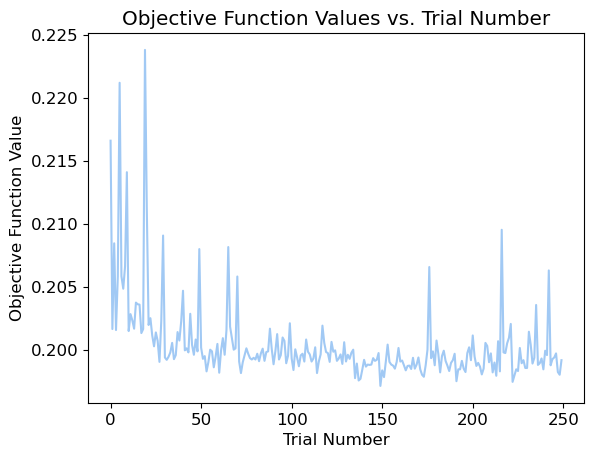

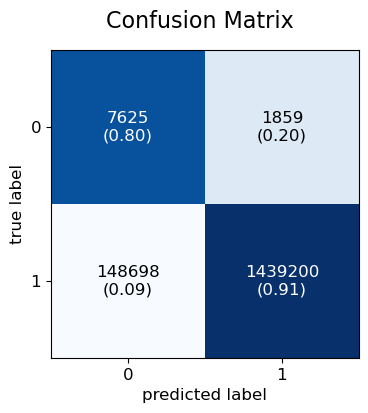

FP rate=FP/(FP+TN):  0.1960
Precision=TP/(TP+FP) :  0.9987
Recall=TP/(TP+FN) :  0.9064
AUC-PR:  0.9983
f1-score:  0.9503
roc_auc:  0.8552
Accuracy:  0.9057



the best hyperparameters are : {'n_estimators': 639, 'learning_rate': 0.1564451816120616, 'max_features': 235, 'min_samples_split': 0.10086195327610623, 'min_samples_leaf': 2, 'max_depth': 10}


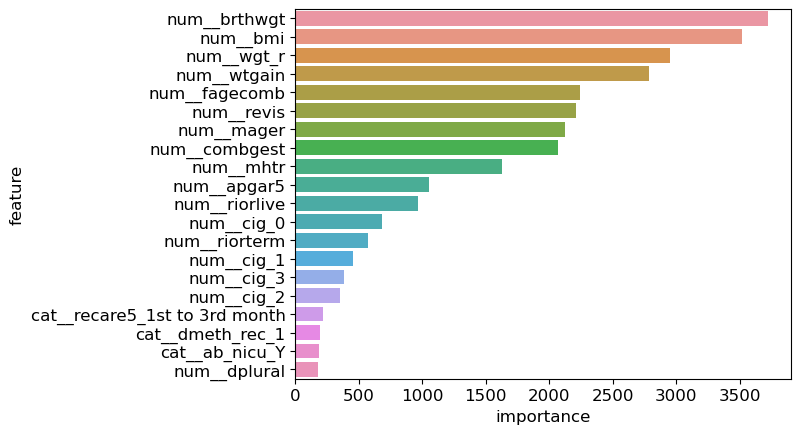

In [103]:
trials_df_lgbm = std_lgbm.trials_dataframe()

sns.lineplot(trials_df_lgbm, x='number',y='value')

plt.xlabel('Trial Number')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Values vs. Trial Number')

static_lgbm=std_lgbm.best_params.copy()

lgbm_tuned=wrapper(LGBMClassifier(**static_lgbm)).fit(xbal,ybal)

performance_result(ytest, lgbm_tuned.predict(xtest))

print("\n\n\nthe best hyperparameters are :", study.best_params)

sns.set_palette("pastel")
sns.barplot(feature_importances(lgbm_tuned).head(20),y='feature',x='importance',orient='h')
plt.show()

### The above LGBM classifier performs very well. 

With these three classifier's hyperparameters tuned, we save the models below.

In [109]:


clf_dict={'LightGBM':lgbm_tuned.pipe,'XGBoost':xgbc.pipe,'GradientBoostingClassifier':gbc_tuned.pipe}
joblib.dump(clf_dict,'clf_dict.joblib')



['clf_dict.joblib']

['clf_dict.joblib']